In [1]:
# Importing all the required Libraries 
import math
import statistics as s
import scipy.stats as scs
import pandas as pd
import numpy as np
import numpy.random as npr
import yfinance as yf
from pylab import plt
from pylab import mpl
import scipy.optimize as sco
import datetime as dt
import seaborn as sb

In [2]:
################################################################################################################################
################################               Define Varaibles               ##################################################
################################################################################################################################

#Define Simulation Key Variables

Rf=0                                     #Risk Free Rate
simulations = 2500                       #Number of simulations to run
market='^GSPC'
extra_asset='ETH-USD'

# Date range
start = dt.datetime(2017,11,20)
end = dt.datetime(2022,2,28)
#Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
interval= '1wk' # Change interval to weekly as ETH trades every day while normal exchanges do not
annualize=52  #Change according to chosen interval
#Define Benchmark
benchmark_assets=['URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX']
benchmark_assets.sort()

#Define Portfolio
portfolio_assets=['ETH-USD','URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX']
portfolio_assets.sort()

#Define Market 
market_assets=['^GSPC','ETH-USD','URTH','IEMG','VPU','VIS','VDE','VHT','VDC','VGT','VBIIX','VBMFX','DBC','VNQ','QALTX'] #we use this to get market variance and covariance for each security
market_assets.sort()

benchmark_returns=[]                     #Benchmark Returns 
benchmark_stds=[]                        #Benchmark Volatility
benchmark_noa=len(benchmark_assets)      #Number of assets in the Benchmark
benchmark_weights_list=[]

portfolio_returns=[]                     #Portfolio Returns 
portfolio_stds=[]                        #Portfolio Volatility
portfolio_noa=len(portfolio_assets)      #Number of assets in the Portfolio
portfolio_weights_list=[]

market_returns=[]                        #Market Returns 
market_var=[]                            #Market Variance

# Market and Porfolio information

market_location=market_assets.index(market)  #Identifies the location of the market reference within the list
market_covariances=[]
market_cov_list=[]
portfolio_betas=[]
benchmark_betas=[]
benchmark_sr_list=[]
portfolio_sr_list=[]
benchmark_tr_list=[]
portfolio_tr_list=[]
benchmark_alpha_list=[]
portfolio_alpha_list=[]
beta_list=[]
betas=[]




In [3]:
################################################################################################################################
################################               Define Functions               ##################################################
################################################################################################################################

# general return and volatility functions ####### NOTE CHANGE FORMULA TO ACCOUNT FOR WEEKLY RETURNS FOR THE THESIS #####

#Function for Benchmark Return and Standard Deviation
def benchmark_return(weights):
    return np.sum(benchmark_rets.mean()*weights)*annualize  # Adjust the formula to account for weekly returns?????

def benchmark_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(benchmark_rets.cov()*annualize,weights))) # Adjust the formula to account for weekly returns?????

def portfolio_return(weights):
    return np.sum(portfolio_rets.mean()*weights)*annualize  # Adjust the formula to account for weekly returns?????

def portfolio_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(portfolio_rets.cov()*annualize,weights))) # Adjust the formula to account for weekly returns?????

def min_portfolio_sharpe(weights):
    return -portfolio_return(weights)/portfolio_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def min_benchmark_sharpe(weights):
    return -benchmark_return(weights)/benchmark_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def Beta(cov,var): #Computing the Beta of each observation
    return cov/var # cov(i,m)/var(m)

def p_beta(weights,beta):
    return np.sum(beta*weights) # computing the beta of a portfolio of assets

def sharpe_ratio(Rf,R,std):  # Defining the function to calculate the Sharpe Ratio
    return (R-Rf)/std

def treynor_ratio(Rf,R,B):  # Defining the function to calculate the Treynor Ratio
    return (R-Rf)/B

def jensens_alpha(Rf,Rm,R,B):  # Defining the function to calculate the Jensen's Alpha
    return R-(Rf+B*(Rm-Rf))


def check_sum(weights):       #fucntion to check if allocation sums to 1
    return np.sum(weights)-1

def product(x):
    p=1
    for i in x:
        p*=i   
    return p


In [4]:
################################################################################################################################
################################                    Download                    ################################################
################################################################################################################################

#Download the Benchmark Data from Yahoo Finance
benchmark_data = yf.download(benchmark_assets, start = start, end = end, interval=interval)
benchmark_data = benchmark_data.loc[:,('Adj Close', slice(None))]
benchmark_data.columns = benchmark_assets
benchmark_nb_rows=benchmark_data.shape[0]
benchmark_data=benchmark_data.dropna()

#Download the Portfolio Data from Yahoo Finance
portfolio_data = yf.download(portfolio_assets, start = start, end = end, interval=interval)
portfolio_data = portfolio_data.loc[:,('Adj Close', slice(None))]
portfolio_data.columns = portfolio_assets
portfolio_nb_rows=portfolio_data.shape[0]
portfolio_data=portfolio_data.dropna()

#Download the Market Benchmark Data from Yahoo Finance
market_data = yf.download(market_assets, start = start, end = end, interval=interval)
market_data = market_data.loc[:,('Adj Close', slice(None))]
market_data.columns = market_assets
market_nb_rows=market_data.shape[0]
market_data=market_data.dropna()





[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  15 of 15 completed


In [5]:
################################################################################################################################
################################                   Basic Computations                     ######################################
################################################################################################################################

#Calculating the rate of return from data
benchmark_rets=np.log(benchmark_data/benchmark_data.shift(1)).dropna() #Calculating return of the Benchmark data using log difference
portfolio_rets=np.log(portfolio_data/portfolio_data.shift(1)).dropna() #Calculating return of the Portfolio data using log difference
market_rets=np.log(market_data/market_data.shift(1)).dropna() #Calculating return of the Market data using log difference

#calculating the average historical return of the market portfolio
market_returns=market_rets.mean()*annualize #Note make sure to annualize properly, and location for alpha

# NOTE: Other Returns Computations are conducted within the Monte Carlo Simulation Loop for efficiency

#Computing the covariances, note that cov(x,x)=var(x), we annualize the covariance matrix
benchmark_covs=benchmark_rets.cov()*annualize
portfolio_covs=portfolio_rets.cov()*annualize
market_covs=market_rets.cov()*annualize

#looping to get covariances in a list in the order they are sorted, check the .head() for reference
j=0
for a in market_assets: 
    market_covariances.append(market_covs.loc[market_assets[market_location],market_assets[j]])
    print(market_assets[j]) 
    market_cov_list.append([market_assets[j],market_covs.loc[market_assets[market_location],market_assets[j]]]) #sets a 2 dimensional array asset name + covariance with market
    j=j+1
     

#Computing Beta of each security # Note that i=position of the market
k=0
for ma in market_assets: #looping to get covariances and compute beta
    betas.append(Beta(market_cov_list[k][1],market_cov_list[market_location][1])) #assigns beta values without names
    beta_list.append([market_assets[k],Beta(market_cov_list[k][1],market_cov_list[market_location][1])])#sets a 2 dimensional array asset name + beta
    k=k+1

betas_port_copy=list.copy(betas)
del betas_port_copy[market_location]

extra_asset_location=market_assets.index(extra_asset)    # Identifying the extra asset in the portfolio
betas_bench_copy=list.copy(betas_port_copy)
del betas_bench_copy[extra_asset_location]               # Removing the extra asset in the portfolio

################################################################################################################################
################################                Monte Carlo Simulation                    ######################################
################################################################################################################################

#Using monte carlo to generate random portfolio weights
#The for iteration is the monte carlo simulaion for the weights

for b in range (simulations):
    benchmark_weights = np.random.random(benchmark_noa)
    benchmark_weights /= np.sum(benchmark_weights)
    benchmark_returns.append(benchmark_return(benchmark_weights))
    benchmark_stds.append(benchmark_std(benchmark_weights))
    benchmark_weights_list.append(benchmark_weights)


for p in range (simulations):
    portfolio_weights = np.random.random(portfolio_noa)
    portfolio_weights /= np.sum(portfolio_weights)
    portfolio_returns.append(portfolio_return(portfolio_weights))
    portfolio_stds.append(portfolio_std(portfolio_weights))
    portfolio_weights_list.append(portfolio_weights)


################################################################################################################################
################################                   Metric Computations                     ######################################
################################################################################################################################

#Computing Benchmark Metrics

benchmark_returns = np.array(benchmark_returns) #### This is causing a non fatal error 
benchmark_stds = np.array(benchmark_stds)
benchmark_weights_list=np.array(benchmark_weights_list)
benchmark_betas = np.dot(benchmark_weights_list,betas_bench_copy) # Calculating the Benchmark Betas

#Computing Portfolio Metrics
portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)
portfolio_weights_list=np.array(portfolio_weights_list)
portfolio_betas = np.dot(portfolio_weights_list,betas_port_copy) # Calculating the Portfolio Betas


# In this section we will compute performance metrics for the benchmark and portfolio 

i=0
for s in range (simulations):
    #sharpe_ratio
    benchmark_sr=sharpe_ratio(Rf,benchmark_returns[i],benchmark_stds[i])
    benchmark_sr_list.append(benchmark_sr) # list of benchmark sharpe ratios
    portfolio_sr=sharpe_ratio(Rf,portfolio_returns[i],portfolio_stds[i])
    portfolio_sr_list.append(portfolio_sr) # list of portfolio sharpe ratios
    
    #treynor_ratio
    benchmark_tr=treynor_ratio(Rf,benchmark_returns[i],benchmark_betas[i])
    benchmark_tr_list.append(benchmark_tr) # list of benchmark sharpe ratios
    portfolio_tr=treynor_ratio(Rf,portfolio_returns[i],portfolio_betas[i])
    portfolio_tr_list.append(portfolio_tr)
    
    #Jensen's Alpha
    benchmark_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_returns[i],benchmark_betas[i])
    benchmark_alpha_list.append(benchmark_alpha) # list of benchmark sharpe ratios
    portfolio_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_returns[i],portfolio_betas[i])
    portfolio_alpha_list.append(portfolio_alpha)
    i=i+1
    

DBC
ETH-USD
IEMG
QALTX
URTH
VBIIX
VBMFX
VDC
VDE
VGT
VHT
VIS
VNQ
VPU
^GSPC


In [6]:
################################################################################################################################
################################                 Optimization Process                     ######################################
################################################################################################################################

##OPTIMIZING THE PORTFOLIO 

#Setting the optimization conditions
portfolio_cons=({'type': 'eq','fun':check_sum}) #Constraint 
portfolio_bounds = tuple((0,1) for x in range(portfolio_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
portfolio_eweights = np.array(portfolio_noa*[1./portfolio_noa,]) # setting equal weights as an initial estimation

#Optimization Command
portfolio_optimization=sco.minimize(min_portfolio_sharpe,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons)  

#Results    
portfolio_opt_weights=portfolio_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
portfolio_opt_return=portfolio_return(portfolio_opt_weights) #Calculating the return of the Optimal Portfolio
portfolio_opt_std=portfolio_std(portfolio_opt_weights) #Calculating the volatility of the Optimal Portfolio
portfolio_opt_beta=p_beta(portfolio_opt_weights,betas_port_copy)#Calculating the Beta of the Optimal Portfolio
portfolio_opt_sr=sharpe_ratio(Rf,portfolio_opt_return,portfolio_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
portfolio_opt_tr=treynor_ratio(Rf,portfolio_opt_return,portfolio_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
portfolio_opt_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_opt_return,portfolio_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 

portfolio_minvar=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons) 

#Results    
portfolio_minvar_weights=portfolio_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
portfolio_minvar_return=portfolio_return(portfolio_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
portfolio_minvar_std=portfolio_std(portfolio_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
portfolio_minvar_beta=p_beta(portfolio_minvar_weights,betas_port_copy)#Calculating the Beta of the Minimuim Variance Portfolio
portfolio_minvar_sr=sharpe_ratio(Rf,portfolio_minvar_return,portfolio_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
portfolio_minvar_tr=treynor_ratio(Rf,portfolio_minvar_return,portfolio_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
portfolio_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_minvar_return,portfolio_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio


#Calculating the Naive portfolio (portfolio with equal weights)
portfolio_naive_weights=portfolio_eweights #calculating the Naive Benchmark weights 
portfolio_naive_return=portfolio_return(portfolio_naive_weights) #Calculating the return of the Naive Benchmark
portfolio_naive_std=portfolio_std(portfolio_naive_weights) #Calculating the volatility of the Naive Benchmark
portfolio_naive_beta=p_beta(portfolio_naive_weights,betas_port_copy)#Calculating the Beta of the Naive Benchmark
portfolio_naive_sr=sharpe_ratio(Rf,portfolio_naive_return,portfolio_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
portfolio_naive_tr=treynor_ratio(Rf,portfolio_naive_return,portfolio_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
portfolio_naive_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_naive_return,portfolio_naive_beta)#Calculating the Alpha the Naive Benchmark


# OPTIMIZING THE BENCHMARK

#Setting the optimization conditions
benchmark_cons=({'type': 'eq','fun':check_sum}) #Constraint 
benchmark_bounds = tuple((0,1) for x in range(benchmark_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
benchmark_eweights = np.array(benchmark_noa*[1./benchmark_noa,]) # setting equal weights as an initial estimation

#Optimization Command
benchmark_optimization=sco.minimize(min_benchmark_sharpe,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons)  

#Results    
benchmark_opt_weights=benchmark_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
benchmark_opt_return=benchmark_return(benchmark_opt_weights) #Calculating the return of the Optimal Portfolio
benchmark_opt_std=benchmark_std(benchmark_opt_weights) #Calculating the volatility of the Optimal Portfolio
benchmark_opt_beta=p_beta(benchmark_opt_weights,betas_bench_copy)#Calculating the Beta of the Optimal Portfolio
benchmark_opt_sr=sharpe_ratio(Rf,benchmark_opt_return,benchmark_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
benchmark_opt_tr=treynor_ratio(Rf,benchmark_opt_return,benchmark_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
benchmark_opt_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_opt_return,benchmark_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 
benchmark_minvar=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons) 

#Results    
benchmark_minvar_weights=benchmark_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
benchmark_minvar_return=benchmark_return(benchmark_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
benchmark_minvar_std=benchmark_std(benchmark_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
benchmark_minvar_beta=p_beta(benchmark_minvar_weights,betas_bench_copy)#Calculating the Beta of the Minimuim Variance Portfolio
benchmark_minvar_sr=sharpe_ratio(Rf,benchmark_minvar_return,benchmark_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
benchmark_minvar_tr=treynor_ratio(Rf,benchmark_minvar_return,benchmark_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
benchmark_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_minvar_return,benchmark_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio

#Calculating the Naive Benchmark (Benchmark with equal weights)
benchmark_naive_weights=benchmark_eweights #calculating the Naive Benchmark weights 
benchmark_naive_return=benchmark_return(benchmark_naive_weights) #Calculating the return of the Naive Benchmark
benchmark_naive_std=benchmark_std(benchmark_naive_weights) #Calculating the volatility of the Naive Benchmark
benchmark_naive_beta=p_beta(benchmark_naive_weights,betas_bench_copy)#Calculating the Beta of the Naive Benchmark
benchmark_naive_sr=sharpe_ratio(Rf,benchmark_naive_return,benchmark_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
benchmark_naive_tr=treynor_ratio(Rf,benchmark_naive_return,benchmark_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
benchmark_naive_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_naive_return,benchmark_naive_beta)#Calculating the Alpha the Naive Benchmark


################################################################################################################################
################################                   Efficient Frontier                     ######################################
################################################################################################################################

# Plotting the Benchmark efficient Frontier 

benchmark_constraint_EF=({'type':'eq','fun': lambda x: benchmark_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
benchmark_bounds_EF= tuple((0,1) for x in benchmark_weights)        # Bounds

benchmark_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
benchmark_target_stds=[]                                   #Target Volatility Variable
for target_return in benchmark_target_returns:
    benchmark_res=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP', bounds=benchmark_bounds_EF, constraints=benchmark_constraint_EF)
    benchmark_target_stds.append(benchmark_res['fun'])
benchmark_target_stds=np.array(benchmark_target_stds)

# Plotting the Portfolio efficient Frontier 
portfolio_eweights = np.array(portfolio_noa*[1./portfolio_noa,])
portfolio_constraint_EF=({'type':'eq','fun': lambda x: portfolio_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
portfolio_bounds_EF= tuple((0,1) for x in portfolio_weights)        # Bounds

portfolio_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
portfolio_target_stds=[]                                   #Target Volatility Variable
for target_return in portfolio_target_returns:
    portfolio_res=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP', bounds=portfolio_bounds_EF, constraints=portfolio_constraint_EF)
    portfolio_target_stds.append(portfolio_res['fun'])
portfolio_target_stds=np.array(portfolio_target_stds)


In [7]:
################################################################################################################################
################################                  Compiling DataFrames                    ######################################
################################################################################################################################

#Generating DF for Portfolio
portfolio_weights_list_df=pd.DataFrame(portfolio_weights_list,columns=portfolio_assets) #Trasnforming arrays to a dataframe
portfolio_returns_df = pd.DataFrame(portfolio_returns,columns=["portfolio_returns"])
portfolio_stds_df = pd.DataFrame(portfolio_stds,columns=["portfolio_stds"])

#Generating DF for Benchmark
benchmark_weights_list_df=pd.DataFrame(benchmark_weights_list,columns=benchmark_assets) #Trasnforming arrays to a dataframe
benchmark_returns_df = pd.DataFrame(benchmark_returns,columns=["benchmark_returns"])
benchmark_stds_df = pd.DataFrame(benchmark_stds,columns=["benchmark_stds"])

#Betas
benchmark_betas_df = pd.DataFrame(benchmark_betas,columns=["Benchmark Beta Values"])
portfolio_betas_df = pd.DataFrame(portfolio_betas,columns=["Portfolio Beta Values"])

#Sharpe Ratios
benchmark_sr_df = pd.DataFrame(benchmark_sr_list,columns=["benchmark_sharpe"])
portfolio_sr_df = pd.DataFrame(portfolio_sr_list,columns=["portfolio_sharpe"])

#Tryenor Ratios
benchmark_tr_df = pd.DataFrame(benchmark_tr_list,columns=["benchmark_treynor"])
portfolio_tr_df = pd.DataFrame(portfolio_tr_list,columns=["portfolio_treynor"])

#Jensen's Alpha
benchmark_alpha_df = pd.DataFrame(benchmark_alpha_list,columns=["benchmark_alpha"])
portfolio_alpha_df = pd.DataFrame(portfolio_alpha_list,columns=["portfolio_alpha"])

#Summarizing the data into a single data frame 
benchmark_df=pd.concat([benchmark_weights_list_df,benchmark_returns_df,benchmark_stds_df,benchmark_betas_df,benchmark_sr_df,benchmark_tr_df,benchmark_alpha_df],axis=1)
portfolio_df=pd.concat([portfolio_weights_list_df,portfolio_returns_df,portfolio_stds_df,portfolio_betas_df,portfolio_sr_df,portfolio_tr_df,portfolio_alpha_df],axis=1)

################################################################################################################################
################################                 Optimization DataFrames                  ######################################
################################################################################################################################

#Defining metrics for dictionary keys
metrics=["Return","Std","Beta","Sharpe","Treynor","Alpha"]

# Creating Optimal portfolio Dataframe
portfolio_opt_dict={}
portfolio_opt_keys=portfolio_assets
portfolio_opt_values=portfolio_opt_weights

portfolio_opt_dict=dict(zip(portfolio_opt_keys,portfolio_opt_values))  #Creating Dictionary

portfolio_opt_metrics=[portfolio_opt_return,portfolio_opt_std,portfolio_opt_beta,portfolio_opt_sr,portfolio_opt_tr,portfolio_opt_alpha]
portfolio_opt_dict.update(dict(zip(metrics,portfolio_opt_metrics)))  #Adding metrics to Dictionar
     
portfolio_opt_df=pd.DataFrame(list(portfolio_opt_dict.items()))
portfolio_opt_df=portfolio_opt_df.set_index([0]).T
portfolio_opt_df.index=["Optimal Portfolio"]

# Creating Naive portfolio Dataframe

portfolio_naive_dict={}
portfolio_naive_keys=portfolio_assets
portfolio_naive_values=portfolio_naive_weights

portfolio_naive_dict=dict(zip(portfolio_naive_keys,portfolio_naive_values)) #Creating Dictionary

portfolio_naive_metrics=[portfolio_naive_return,portfolio_naive_std,portfolio_naive_beta,portfolio_naive_sr,portfolio_naive_tr,portfolio_naive_alpha]
portfolio_naive_dict.update(dict(zip(metrics,portfolio_naive_metrics)))  #Adding metrics to Dictionar
     
portfolio_naive_df=pd.DataFrame(list(portfolio_naive_dict.items()))
portfolio_naive_df=portfolio_naive_df.set_index([0]).T
portfolio_naive_df.index=["Naive Portfolio"]

# Creating Minimuim Variance portfolio Dataframe

portfolio_minvar_dict={}
portfolio_minvar_keys=portfolio_assets
portfolio_minvar_values=portfolio_minvar_weights

portfolio_minvar_dict=dict(zip(portfolio_minvar_keys,portfolio_minvar_values)) # Creating Dictionary

portfolio_minvar_metrics=[portfolio_minvar_return,portfolio_minvar_std,portfolio_minvar_beta,portfolio_minvar_sr,portfolio_minvar_tr,portfolio_minvar_alpha]
portfolio_minvar_dict.update(dict(zip(metrics,portfolio_minvar_metrics)))  #Adding metrics to Dictionar

portfolio_minvar_df=pd.DataFrame(list(portfolio_minvar_dict.items()))
portfolio_minvar_df=portfolio_minvar_df.set_index([0]).T
portfolio_minvar_df.index=["Minvar Portfolio"]


# Creating Optimal Benchmark Dataframe
benchmark_opt_dict={}
benchmark_opt_keys=benchmark_assets
benchmark_opt_values=benchmark_opt_weights

benchmark_opt_dict=dict(zip(benchmark_opt_keys,benchmark_opt_values))  #Creating Dictionary

benchmark_opt_metrics=[benchmark_opt_return,benchmark_opt_std,benchmark_opt_beta,benchmark_opt_sr,benchmark_opt_tr,benchmark_opt_alpha]
benchmark_opt_dict.update(dict(zip(metrics,benchmark_opt_metrics)))  #Adding metrics to Dictionar
     
benchmark_opt_df=pd.DataFrame(list(benchmark_opt_dict.items()))
benchmark_opt_df=benchmark_opt_df.set_index([0]).T
benchmark_opt_df.index=["Optimal Benchmark"]

# Creating Naive Benchmark Dataframe
benchmark_naive_dict={}
benchmark_naive_keys=benchmark_assets
benchmark_naive_values=benchmark_naive_weights

benchmark_naive_dict=dict(zip(benchmark_naive_keys,benchmark_naive_values))  #Creating Dictionary

benchmark_naive_metrics=[benchmark_naive_return,benchmark_naive_std,benchmark_naive_beta,benchmark_naive_sr,benchmark_naive_tr,benchmark_naive_alpha]
benchmark_naive_dict.update(dict(zip(metrics,benchmark_naive_metrics)))  #Adding metrics to Dictionar

benchmark_naive_df=pd.DataFrame(list(benchmark_naive_dict.items()))
benchmark_naive_df=benchmark_naive_df.set_index([0]).T
benchmark_naive_df.index=["Naive Benchmark"]

# Creating Minimuim Variance Benchmark Dataframe
benchmark_minvar_dict={}
benchmark_minvar_keys=benchmark_assets
benchmark_minvar_values=benchmark_minvar_weights

benchmark_minvar_dict=dict(zip(benchmark_minvar_keys,benchmark_minvar_values))  #Creating Dictionary

benchmark_minvar_metrics=[benchmark_minvar_return,benchmark_minvar_std,benchmark_minvar_beta,benchmark_minvar_sr,benchmark_minvar_tr,benchmark_minvar_alpha]
benchmark_minvar_dict.update(dict(zip(metrics,benchmark_minvar_metrics)))  #Adding metrics to Dictionar

benchmark_minvar_df=pd.DataFrame(list(benchmark_minvar_dict.items()))
benchmark_minvar_df=benchmark_minvar_df.set_index([0]).T
benchmark_minvar_df.index=["Minvar Benchmark"]


#Summarizing Optimization DataFrames
portfolio_summary_df=pd.concat([portfolio_minvar_df.T,portfolio_naive_df.T,portfolio_opt_df.T],axis=1)
benchmark_summary_df=pd.concat([benchmark_minvar_df.T,benchmark_naive_df.T,benchmark_opt_df.T],axis=1)




In [30]:
################################################################################################################################
################################                 Exporting Data as CSV                    ######################################
################################################################################################################################

benchmark_rets.to_csv("benchreturns.csv") #Generating Benchmark returns data from prices
portfolio_rets.to_csv("portreturns.csv")  #Generating Portfolio returns data from prices
market_rets.to_csv("marketreturns.csv")  #Generating Portfolio returns data from prices

#Generating csv file for Portfolio related CSV Files

portfolio_weights_list_df.to_csv("portfolio_weights_list.csv") #Generating CSV files 
portfolio_returns_df.to_csv("portfolio_returns_df.csv")        #Generating CSV files 
portfolio_stds_df.to_csv("portfolio_stds_df.csv")              #Generating CSV files 
portfolio_betas_df.to_csv("portfolio_betas_df.csv")

#Generating csv file for Benchmark related CSV Files

benchmark_weights_list_df.to_csv("benchmark_weights_list.csv") #Generating CSV files 
benchmark_returns_df.to_csv("benchmark_returns_df.csv")        #Generating CSV files 
benchmark_stds_df.to_csv("benchmark_stds_df.csv")              #Generating CSV files 
benchmark_betas_df.to_csv("benchmark_betas_df.csv")

#Summarizing the data into a single CSV File

benchmark_df.to_csv("benchmark_df.csv") 
portfolio_df.to_csv("portfolio_df.csv")

portfolio_summary_df.to_csv("portfolio_summary_df.csv")
benchmark_summary_df.to_csv("benchmark_summary_df.csv")

#portfolio_data.to_csv("portfoliodata.csv")  #writes a csv file to current location

In [61]:
################################################################################################################################
################################                   Generating Graphs                      ######################################
################################################################################################################################



,DBC,ETH-USD,IEMG,QALTX,URTH,VBIIX,VBMFX,VDC,VDE,VGT,VHT,VIS,VNQ,VPU,^GSPC
Date,,,,,,,,,,,,,,,
2017-11-20,15.973323,471.329987,50.617352,1.306850,79.687859,10.083366,9.710656,125.999397,79.139908,160.417236,143.131363,126.115364,72.015244,107.696190,2602.419922
2017-11-27,15.837296,465.852997,48.899857,1.300468,80.173996,10.065693,9.701641,129.359985,81.258812,156.908051,145.730865,129.817780,71.710052,108.949181,2642.219971
2017-12-04,15.506948,441.721008,48.847015,1.304297,80.329926,10.086946,9.721537,130.256119,80.552513,156.908051,145.102081,131.238907,71.235313,107.941513,2651.500000
2017-12-11,15.390354,719.974976,49.146473,1.315783,80.669289,10.095800,9.739606,130.569763,79.829185,159.164642,145.993622,131.061249,72.125443,106.197823,2675.810059
2017-12-18,15.740136,694.148010,49.419510,1.322164,80.806870,10.016099,9.676365,131.829239,84.404587,159.471848,145.593460,133.299988,69.370316,102.435638,2683.340088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,22.340000,2603.466553,57.799999,9.540000,125.940002,11.592000,10.922999,194.770004,90.790001,409.839996,242.279999,187.429993,104.949997,148.389999,4431.850098
2022-01-31,22.830000,3057.476074,59.400002,9.730000,128.220001,11.482171,10.813170,194.970001,95.180000,416.079987,246.440002,188.669998,105.019997,149.100006,4500.529785
2022-02-07,23.129999,2883.463379,59.430000,9.810000,126.639999,11.470000,10.780000,194.220001,97.220001,405.959991,243.779999,187.610001,103.269997,145.880005,4418.640137


,DBC,ETH-USD,IEMG,QALTX,URTH,VBIIX,VBMFX,VDC,VDE,VGT,VHT,VIS,VNQ,VPU,^GSPC
Date,,,,,,,,,,,,,,,
2017-11-27,-0.008552,-0.011688,-0.034520,-0.004895,0.006082,-0.001754,-0.000929,0.026322,0.026422,-0.022118,0.017999,0.028935,-0.004247,0.011567,0.015178
2017-12-04,-0.021079,-0.053192,-0.001081,0.002940,0.001943,0.002109,0.002049,0.006904,-0.008730,0.000000,-0.004324,0.010888,-0.006642,-0.009292,0.003506
2017-12-11,-0.007547,0.488538,0.006112,0.008768,0.004216,0.000877,0.001857,0.002405,-0.009020,0.014279,0.006125,-0.001355,0.012418,-0.016286,0.009127
2017-12-18,0.022473,-0.036531,0.005540,0.004838,0.001704,-0.007926,-0.006514,0.009600,0.055733,0.001928,-0.002745,0.016937,-0.038948,-0.036069,0.002810
2017-12-25,0.024994,0.086325,0.031384,-0.030379,0.009449,0.005383,0.004195,-0.000137,0.003949,-0.009726,-0.002850,0.002955,0.029329,0.004987,-0.003633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,0.014882,0.026635,-0.033850,-0.006270,-0.001983,-0.005155,-0.004560,-0.005377,0.049446,0.018246,0.003680,-0.019077,-0.002664,-0.011391,0.007681
2022-01-31,0.021697,0.160746,0.027305,0.019720,0.017942,-0.009520,-0.010106,0.001026,0.047221,0.015111,0.017024,0.006594,0.000667,0.004773,0.015378
2022-02-07,0.013055,-0.058598,0.000505,0.008188,-0.012399,-0.001061,-0.003072,-0.003854,0.021207,-0.024623,-0.010852,-0.005634,-0.016804,-0.021833,-0.018363


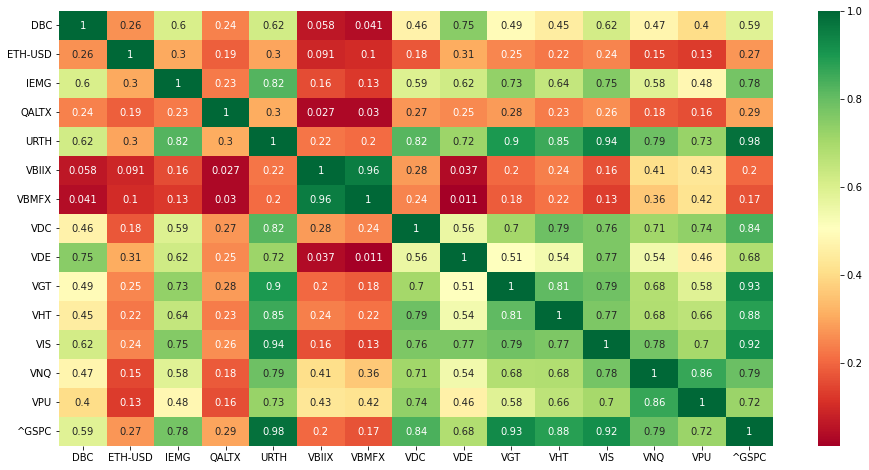

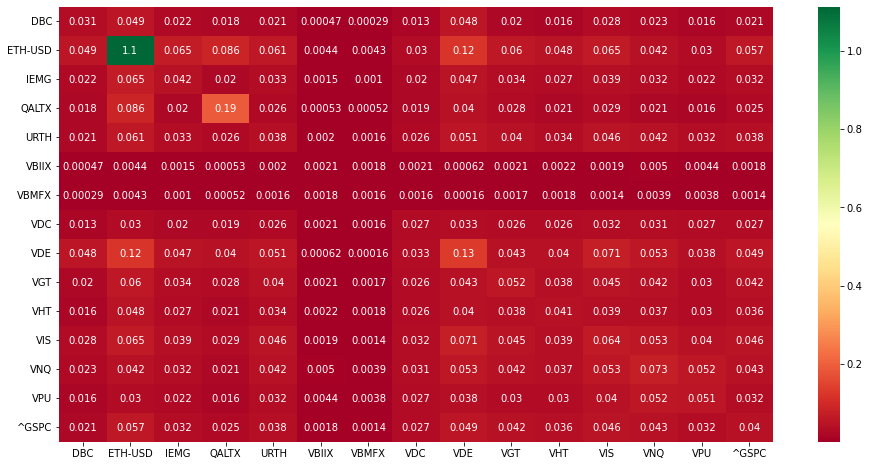

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DBC,0.044900,0.128820,0.095792,0.047237,0.140526,0.037967,0.080497,0.100379,0.055886,0.012358,...,0.020807,0.190476,0.104205,0.058707,0.146872,0.071353,0.046691,0.140721,0.014754,0.025032
IEMG,0.036566,0.089666,0.114250,0.174592,0.048790,0.112150,0.081094,0.152830,0.132204,0.105606,...,0.079451,0.031445,0.140596,0.120034,0.005141,0.098489,0.093850,0.063519,0.002595,0.089633
QALTX,0.113496,0.007514,0.143740,0.041816,0.082931,0.105471,0.086533,0.082871,0.089195,0.029556,...,0.001736,0.013736,0.035314,0.104919,0.140364,0.146340,0.086167,0.016774,0.169012,0.016255
URTH,0.050662,0.124987,0.043551,0.081347,0.026449,0.137331,0.018327,0.021717,0.073917,0.068960,...,0.079499,0.088703,0.006662,0.122899,0.044899,0.118004,0.103433,0.120538,0.015970,0.144101
VBIIX,0.006719,0.073486,0.017926,0.031102,0.079910,0.008646,0.107090,0.057095,0.124567,0.129559,...,0.000455,0.055151,0.015491,0.043234,0.089885,0.125411,0.072080,0.077197,0.145036,0.011113
VBMFX,0.135100,0.041392,0.007722,0.026487,0.127583,0.004425,0.000036,0.091348,0.093907,0.080560,...,0.141925,0.056411,0.072017,0.015689,0.046602,0.035204,0.080926,0.057387,0.015806,0.073283
VDC,0.128317,0.020646,0.127061,0.077602,0.107464,0.026752,0.147877,0.092421,0.020087,0.097161,...,0.118306,0.072006,0.088377,0.040912,0.014900,0.135868,0.104017,0.090753,0.173693,0.083071
VDE,0.103914,0.133268,0.065628,0.122044,0.048149,0.113913,0.106453,0.030772,0.069216,0.086258,...,0.081135,0.099799,0.104180,0.097982,0.136425,0.067350,0.029626,0.107413,0.035950,0.105067
VGT,0.074764,0.057121,0.112338,0.100889,0.049733,0.065186,0.082862,0.061518,0.021068,0.052922,...,0.187777,0.177396,0.118505,0.117704,0.049442,0.005128,0.106051,0.051117,0.067591,0.046185
VHT,0.041365,0.092166,0.130933,0.011831,0.111955,0.180330,0.010361,0.075407,0.136052,0.131248,...,0.020017,0.005398,0.036430,0.110187,0.140140,0.016401,0.001555,0.089095,0.012796,0.139370


,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DBC,0.148256,0.066788,0.126900,0.087813,0.121234,0.012324,0.055580,0.100296,0.102853,0.033357,...,0.026968,0.100266,0.013930,0.044585,0.012268,0.127152,0.038105,0.168625,0.116934,0.041802
ETH-USD,0.025891,0.109854,0.033017,0.078925,0.027505,0.068223,0.121655,0.084677,0.043515,0.012287,...,0.033861,0.096241,0.151555,0.091497,0.064439,0.100597,0.095219,0.019071,0.143161,0.099712
IEMG,0.019572,0.083803,0.122846,0.031766,0.042934,0.098117,0.048513,0.096351,0.069073,0.152368,...,0.164621,0.051265,0.102567,0.121892,0.008735,0.112876,0.005484,0.043215,0.070492,0.064289
QALTX,0.044587,0.067254,0.033081,0.113052,0.049711,0.068263,0.139066,0.030522,0.041888,0.014019,...,0.017754,0.117821,0.016348,0.022383,0.051118,0.062333,0.030916,0.014154,0.080699,0.057219
URTH,0.149195,0.118646,0.137736,0.113270,0.075013,0.078528,0.071385,0.031957,0.108086,0.086197,...,0.035675,0.096683,0.076152,0.028594,0.076799,0.105547,0.081826,0.033636,0.022617,0.095796
VBIIX,0.141551,0.002628,0.063618,0.033685,0.093289,0.085152,0.096637,0.088330,0.025771,0.038262,...,0.167315,0.070825,0.042302,0.078593,0.122700,0.026941,0.134576,0.154512,0.033719,0.115991
VBMFX,0.126208,0.006443,0.072899,0.089373,0.018777,0.124168,0.121231,0.070574,0.046954,0.061481,...,0.105535,0.059921,0.072097,0.031886,0.118149,0.065125,0.050139,0.057939,0.057952,0.014630
VDC,0.002586,0.130806,0.107170,0.101308,0.060529,0.098422,0.025878,0.085097,0.119576,0.025561,...,0.109458,0.067920,0.003908,0.054791,0.113172,0.020128,0.050563,0.062266,0.098435,0.113968
VDE,0.069823,0.048600,0.010342,0.078479,0.014716,0.016443,0.021638,0.000233,0.105348,0.046569,...,0.112528,0.110053,0.117873,0.130540,0.129910,0.058896,0.044824,0.166120,0.091526,0.093664
VGT,0.059102,0.047396,0.038190,0.009661,0.040127,0.130032,0.094971,0.026560,0.006193,0.106444,...,0.024504,0.074140,0.118038,0.111051,0.084066,0.037615,0.138209,0.053411,0.125971,0.108741


In [9]:
################################################################################################################################
###########################                    Generating Graphs and Figures                     ###############################
################################################################################################################################

# General Statistics
import dataframe_image as dfi


#Step 1 (NOT EXPORTED)     ########################################
display(market_data) # Present data and discuss it as an initial result then discuss rets, std, cov, etc...
display(market_rets) #Present the returns and discuss further calculations 

#Step 2
#present the covariance matrix  (DONE) (EXPORTED)
#present the correlation matrix (DONE) (EXPORTED)

#Generating the Correlation Matrix
fig = plt.figure(figsize = (16, 8))
dataplot=sb.heatmap(market_rets.corr(),cmap='RdYlGn' ,annot=True)
plt.savefig("Correlation Matrix.png")
plt.show()

#Generating the Covariance Matrix
fig = plt.figure(figsize = (16, 8))
dataplot=sb.heatmap(market_covs,cmap='RdYlGn' ,annot=True)
plt.savefig("Covariance Matrix.png")
plt.show()

#Step 3
#Present the Betas of the securities (DONE) (EXPORTED)
beta_list_df=pd.DataFrame(beta_list,columns=["Assets","Betas"])
dfi.export(beta_list_df,'beta_list_df.png')


#present the simulated portfolios and benchmarks (DONE) (NOT EXPORTED)
display(benchmark_df.T)                  ########################################
display(portfolio_df.T)                  ########################################



In [169]:
#benchmark_df.to_csv("benchmark_df.csv") 
#portfolio_df.to_csv("portfolio_df.csv")

#portfolio_summary_df.to_csv("portfolio_summary_df.csv")
#benchmark_summary_df.to_csv("benchmark_summary_df.csv")
#type(market_data)

In [170]:
#benchmark_weights_list_df.describe().T

In [171]:
#beta_list_df=pd.DataFrame(beta_list,columns=["Assets","Betas"])
#display(beta_list_df)

In [10]:

#Step 4
#present the descriptive statistics (DONE) (EXPORTED)
#Descriptive statistics for assets, portfolios, and benchmarks


market_descriptive=(market_rets.describe()).T
portfolios_descriptive=(portfolio_df.describe()).T
benchmarks_descriptive=(benchmark_df.describe()).T


dfi.export(benchmarks_descriptive,'benchmarks_descriptive.png')
dfi.export(portfolios_descriptive,'portfolios_descriptive.png')
dfi.export(market_descriptive,'market_descriptive.png')

#histogram for each asset is possible


#a=df.agg({ variable:[stat1,stat2,etc...]}) ['median' 'skew' 'count' 'sum' 'mean' 'median' 'mode' 'std' 'min' 'max' 'abs' 'prod'
#                                              'cov' 'pct_change' 'corr' 'cumsum' 'sumprod']
#display(assets_descriptive.T)

# Generating Table and Interpretation for Market summary Statistics
skew_df=pd.DataFrame(market_rets.skew(),columns=['skew'])
kurtosis_df=pd.DataFrame(market_rets.kurtosis(),columns=['kurtosis'])

market_statistics_df=pd.concat([market_descriptive,skew_df],axis=1)
display(market_statistics_df)
dfi.export(market_statistics_df,'market_descriptive.png')

market_statistics_statements=[]
for asset in market_assets:
    ms1='Running descriptive statistical analysis on the returns of all the assets used in this study, the summary statistics table above is obtained, and we observe the following results:\n'
    ms2=('The mean return of ' + str(asset)  + ' is '+str(market_statistics_df.loc[asset,'mean'])+', and the median return is ' + str(market_statistics_df.loc[asset,'50%']) +'.')
    
    if market_statistics_df.loc[asset,'mean'] > market_statistics_df.loc[asset,'50%']:
        msk=(' The data appears to be skewed to the right with skewness equal to ' + str(market_statistics_df.loc[asset,'skew']) + ', explaining why the mean is greater than the median.')
                                                                                                                                 
    if market_statistics_df.loc[asset,'mean'] < market_statistics_df.loc[asset,'50%']:
        msk=(' The data appears to be skewed to the left with skewness equal to ' + str(market_statistics_df.loc[asset,'skew']) + ', explaining why the mean is smaller than the median.')           
    
    mstds=(' Moreover, the standard deviation is '+ str(market_statistics_df.loc[asset,'std'])+',')
    mranges=(' and the returns ranged between a minimum of '+ str(market_statistics_df.loc[asset,'min'])+' and a maximum of '+ str(market_statistics_df.loc[asset,'max'])+'.')
    market_statistics_statements.append(ms2+msk+mstds+mranges+'\n\n')
    
market_statistics_interpretation=''
for statement in market_statistics_statements: market_statistics_interpretation = market_statistics_interpretation + statement
market_statistics_interpretation=ms1 +'\n\n'+ market_statistics_interpretation
print(market_statistics_interpretation)


path ="C:/Users/Zeina/"

#Exporting the interpretation
with open(path+'market_statistics_interpretation.txt','w') as f:
    f.write(market_statistics_interpretation)
    f.close()



    
##########################################################################
########### Generate Descriptive statistics interpetation ################
##########################################################################



,count,mean,std,min,25%,50%,75%,max,skew
DBC,222.0,0.001733,0.024582,-0.101606,-0.011814,0.002757,0.018183,0.070110,-0.915918
ETH-USD,222.0,0.007730,0.146294,-0.530968,-0.055612,0.013974,0.085475,0.488538,-0.404960
IEMG,222.0,0.000608,0.028482,-0.147288,-0.014570,0.001269,0.017855,0.080999,-0.817715
QALTX,222.0,0.009048,0.060249,-0.111491,-0.005237,0.002188,0.009459,0.393001,5.254787
URTH,222.0,0.002038,0.027045,-0.148661,-0.008689,0.004732,0.015039,0.110128,-1.253645
VBIIX,222.0,0.000557,0.006351,-0.036634,-0.002476,0.000831,0.003640,0.024443,-1.190029
VBMFX,222.0,0.000441,0.005577,-0.034999,-0.001813,0.000890,0.003420,0.026859,-0.942826
VDC,222.0,0.001992,0.022738,-0.110350,-0.006900,0.003254,0.013285,0.065812,-1.392780
VDE,222.0,0.000841,0.050681,-0.300470,-0.019717,0.004801,0.028372,0.156447,-1.118135
VGT,222.0,0.004159,0.031721,-0.156162,-0.011827,0.008362,0.023037,0.105195,-0.777851


Running descriptive statistical analysis on the returns of all the assets used in this study, the summary statistics table above is obtained, and we observe the following results:


The mean return of DBC is 0.001733346714510416, and the median return is 0.0027573147146045824. The data appears to be skewed to the left with skewness equal to -0.9159177020879926, explaining why the mean is smaller than the median. Moreover, the standard deviation is 0.02458207815846141, and the returns ranged between a minimum of -0.10160577057700305 and a maximum of 0.07010962723461378.

The mean return of ETH-USD is 0.007729993680563415, and the median return is 0.013973734250871865. The data appears to be skewed to the left with skewness equal to -0.4049595573276876, explaining why the mean is smaller than the median. Moreover, the standard deviation is 0.1462940140782702, and the returns ranged between a minimum of -0.5309684855669796 and a maximum of 0.48853797542960353.

The mean return of IEMG is 

In [11]:


word_list=['expected returns', 'standard deviation','beta','Sharpe ratio','Treynor\'s ratio','Jensen\'s alpha']

#Generating statistics for simulated Benchmarks

benchmarks_descriptive=(benchmark_df.describe()).T
display(benchmarks_descriptive)


benchmarks_skew_df=pd.DataFrame(benchmark_rets.skew(),columns=['skew'])
benchmarks_kurtosis_df=pd.DataFrame(benchmark_rets.kurtosis(),columns=['kurtosis'])

benchmarks_statistics_df=pd.concat([benchmarks_descriptive,benchmarks_skew_df],axis=1)
display(benchmarks_statistics_df)
dfi.export(benchmarks_statistics_df,'benchmarks_descriptive.png')

benchmark_word_list=['benchmark_returns','benchmark_stds','Benchmark Beta Values','benchmark_sharpe','benchmark_treynor','benchmark_alpha']
benchmarks_statistics_statements=[]

for asset in (benchmark_assets): ### Interpreting the weights distribution of the the simulated benchmark
    bs1='Running descriptive statistical analysis on the weights of all the assets used to construct the benchmark, the summary statistics table above is obtained, and we observe the following results:\n'
    bs2=('The mean weight of ' + str(asset)  + ' is '+str(benchmarks_statistics_df.loc[asset,'mean'])+', and the median weight is ' + str(benchmarks_statistics_df.loc[asset,'50%']) +'.')
    
    if benchmarks_statistics_df.loc[asset,'mean'] > benchmarks_statistics_df.loc[asset,'50%']:
        bsk=(' The data appears to be skewed to the right with skewness equal to ' + str(benchmarks_statistics_df.loc[asset,'skew']) + ', explaining why the mean is greater than the median.')
                                                                                                                                 
    if benchmarks_statistics_df.loc[asset,'mean'] < benchmarks_statistics_df.loc[asset,'50%']:
        bsk=(' The data appears to be skewed to the left with skewness equal to ' + str(benchmarks_statistics_df.loc[asset,'skew']) + ', explaining why the mean is smaller than the median.')           
    
    bstds=(' Moreover, the standard deviation is '+ str(benchmarks_statistics_df.loc[asset,'std'])+',')
    branges=(' and the weights ranged between a minimum of '+ str(benchmarks_statistics_df.loc[asset,'min'])+' and a maximum of '+ str(benchmarks_statistics_df.loc[asset,'max'])+'.')
    benchmarks_statistics_statements.append(bs2+bsk+bstds+branges+'\n\n')

benchmarks_statistics_interpretation=''
for statement in benchmarks_statistics_statements: benchmarks_statistics_interpretation = benchmarks_statistics_interpretation + statement
benchmarks_statistics_interpretation=bs1 +'\n\n'+ benchmarks_statistics_interpretation
    
### Interpreting the metrics distribution of the the simulated benchmark
benchmarks_statistics_statements2=[]
for asset,word in zip(benchmark_word_list,word_list): 
    bs11='Running descriptive statistical analysis on the performance metrics of all the simulated benchmarks, the summary statistics table above is obtained, and we observe the following results:\n'
    bs2=('The mean '+ str(word) + ' of the simulated benchmarks is '+str(benchmarks_statistics_df.loc[asset,'mean'])+', and the median ' + str(word) + ' was ' + str(benchmarks_statistics_df.loc[asset,'50%']) +'.')
    
    bstds=(' Moreover, the standard deviation is '+ str(benchmarks_statistics_df.loc[asset,'std'])+',')
    branges=(' and the ' + str(word) + ' ranged between a minimum of '+ str(benchmarks_statistics_df.loc[asset,'min'])+' and a maximum of '+ str(benchmarks_statistics_df.loc[asset,'max'])+'.')
    benchmarks_statistics_statements2.append(bs2+bstds+branges+'\n\n')
    
    
benchmarks_statistics_interpretation2=''
for statement2 in benchmarks_statistics_statements2: benchmarks_statistics_interpretation2 = benchmarks_statistics_interpretation2 + statement2
benchmarks_statistics_interpretation2=bs11 +'\n\n'+ benchmarks_statistics_interpretation2
#print(benchmarks_statistics_interpretation)

benchmarks_statistics_interpretation3 = benchmarks_statistics_interpretation + '\n' + benchmarks_statistics_interpretation2

print(benchmarks_statistics_interpretation3)
path ="C:/Users/Zeina/"

#Exporting the interpretation
with open(path+'benchmarks_statistics_interpretation.txt','w') as f:
    f.write(benchmarks_statistics_interpretation3)
    f.close()

###############################################################################################################################

#Generating statistics for simulated portfolios

,count,mean,std,min,25%,50%,75%,max
DBC,2500.0,0.076496,0.044734,0.000033,0.038538,0.075753,0.112287,0.253038
IEMG,2500.0,0.077411,0.044156,0.000238,0.040144,0.076918,0.111682,0.209624
QALTX,2500.0,0.076251,0.044116,0.000084,0.040131,0.075367,0.111359,0.215346
URTH,2500.0,0.078264,0.044235,0.000068,0.040637,0.078155,0.113707,0.218400
VBIIX,2500.0,0.077672,0.044438,0.000042,0.039688,0.079047,0.112018,0.253397
VBMFX,2500.0,0.076312,0.044304,0.000025,0.039201,0.076229,0.110710,0.256975
VDC,2500.0,0.077617,0.044876,0.000004,0.040721,0.077081,0.113114,0.350412
VDE,2500.0,0.078161,0.044524,0.000060,0.041080,0.078409,0.112151,0.225060
VGT,2500.0,0.074845,0.044313,0.000061,0.036864,0.074415,0.109144,0.229900
VHT,2500.0,0.076296,0.044228,0.000043,0.038847,0.076552,0.110912,0.238357


,count,mean,std,min,25%,50%,75%,max,skew
DBC,2500.0,0.076496,0.044734,0.000033,0.038538,0.075753,0.112287,0.253038,-0.915918
IEMG,2500.0,0.077411,0.044156,0.000238,0.040144,0.076918,0.111682,0.209624,-0.817715
QALTX,2500.0,0.076251,0.044116,0.000084,0.040131,0.075367,0.111359,0.215346,5.254786
URTH,2500.0,0.078264,0.044235,0.000068,0.040637,0.078155,0.113707,0.218400,-1.253645
VBIIX,2500.0,0.077672,0.044438,0.000042,0.039688,0.079047,0.112018,0.253397,-1.190022
VBMFX,2500.0,0.076312,0.044304,0.000025,0.039201,0.076229,0.110710,0.256975,-0.942802
VDC,2500.0,0.077617,0.044876,0.000004,0.040721,0.077081,0.113114,0.350412,-1.392780
VDE,2500.0,0.078161,0.044524,0.000060,0.041080,0.078409,0.112151,0.225060,-1.118135
VGT,2500.0,0.074845,0.044313,0.000061,0.036864,0.074415,0.109144,0.229900,-0.777853
VHT,2500.0,0.076296,0.044228,0.000043,0.038847,0.076552,0.110912,0.238357,-0.900820


Running descriptive statistical analysis on the weights of all the assets used to construct the benchmark, the summary statistics table above is obtained, and we observe the following results:


The mean weight of DBC is 0.07649563903879024, and the median weight is 0.07575314211047046. The data appears to be skewed to the right with skewness equal to -0.9159177020879926, explaining why the mean is greater than the median. Moreover, the standard deviation is 0.04473395116606276, and the weights ranged between a minimum of 3.2728433629576835e-05 and a maximum of 0.2530375429814947.

The mean weight of IEMG is 0.07741089422459643, and the median weight is 0.07691841073864218. The data appears to be skewed to the right with skewness equal to -0.8177153427349633, explaining why the mean is greater than the median. Moreover, the standard deviation is 0.04415597315945444, and the weights ranged between a minimum of 0.0002377917580349214 and a maximum of 0.2096239656218053.

The mean weight o

In [18]:

#Generating statistics for simulated portfolios

portfolios_descriptive=(portfolio_df.describe()).T
display(portfolios_descriptive)


portfolios_skew_df=pd.DataFrame(portfolio_rets.skew(),columns=['skew'])
portfolios_kurtosis_df=pd.DataFrame(portfolio_rets.kurtosis(),columns=['kurtosis'])

portfolios_statistics_df=pd.concat([portfolios_descriptive,portfolios_skew_df],axis=1)
display(portfolios_statistics_df)
dfi.export(portfolios_statistics_df,'portfolios_descriptive.png')

portfolio_word_list=['portfolio_returns','portfolio_stds','Portfolio Beta Values','portfolio_sharpe','portfolio_treynor','portfolio_alpha']
portfolios_statistics_statements=[]
portfolios_statistics_statements2=[]
for asset in (portfolio_assets): ### Interpreting the weights distribution of the the simulated portfolios
    ps1='Running descriptive statistical analysis on the weights of all the assets used to construct the portfolio, the summary statistics table above is obtained, and we observe the following results:\n'
    ps2=('The mean weight of ' + str(asset)  + ' is '+str(portfolios_statistics_df.loc[asset,'mean'])+', and the median weight is ' + str(portfolios_statistics_df.loc[asset,'50%']) +'.')
    
    if portfolios_statistics_df.loc[asset,'mean'] > portfolios_statistics_df.loc[asset,'50%']:
        psk=(' The data appears to be skewed to the right with skewness equal to ' + str(portfolios_statistics_df.loc[asset,'skew']) + ', explaining why the mean is greater than the median.')
                                                                                                                                 
    if portfolios_statistics_df.loc[asset,'mean'] < portfolios_statistics_df.loc[asset,'50%']:
        psk=(' The data appears to be skewed to the left with skewness equal to ' + str(portfolios_statistics_df.loc[asset,'skew']) + ', explaining why the mean is smaller than the median.')           
    
    pstds=(' Moreover, the standard deviation is '+ str(portfolios_statistics_df.loc[asset,'std'])+',')
    pranges=(' and the weights ranged between a minimum of '+ str(portfolios_statistics_df.loc[asset,'min'])+' and a maximum of '+ str(portfolios_statistics_df.loc[asset,'max'])+'.')
    portfolios_statistics_statements.append(ps2+psk+pstds+pranges+'\n\n')

portfolios_statistics_interpretation=''
for statement in portfolios_statistics_statements: portfolios_statistics_interpretation = portfolios_statistics_interpretation + statement
portfolios_statistics_interpretation=ps1 +'\n\n'+ portfolios_statistics_interpretation
    

### Interpreting the metrics distribution of the the simulated portfolio
for asset,word in zip(portfolio_word_list,word_list): 
    ps11='Running descriptive statistical analysis on the performance metrics of all the simulated portfolios, the summary statistics table above is obtained, and we observe the following results:\n'
    ps2=('The mean '+ str(word) + ' of the simulated portfolio is '+str(portfolios_statistics_df.loc[asset,'mean'])+', and the median ' + str(word) + ' was ' + str(portfolios_statistics_df.loc[asset,'50%']) +'.')
    
    pstds=(' Moreover, the standard deviation is '+ str(portfolios_statistics_df.loc[asset,'std'])+',')
    pranges=(' and the ' + str(word) + ' ranged between a minimum of '+ str(portfolios_statistics_df.loc[asset,'min'])+' and a maximum of '+ str(portfolios_statistics_df.loc[asset,'max'])+'.')
    portfolios_statistics_statements2.append(ps2+pstds+pranges+'\n\n')
    
portfolios_statistics_interpretation2=''
for statement2 in portfolios_statistics_statements2: portfolios_statistics_interpretation2 = portfolios_statistics_interpretation2 + statement2
portfolios_statistics_interpretation2=ps11 +'\n\n'+ portfolios_statistics_interpretation2
#print(benchmarks_statistics_interpretation)

portfolios_statistics_interpretation3 = portfolios_statistics_interpretation + '\n' + portfolios_statistics_interpretation2

print(portfolios_statistics_interpretation3)


path ="C:/Users/Zeina/"

#Exporting the interpretation
with open(path+'portfolios_statistics_interpretation.txt','w') as f:
    f.write(portfolios_statistics_interpretation3)
    f.close()
    
#print(portfolios_statistics_statements)
#print(portfolios_statistics_statements2)

,count,mean,std,min,25%,50%,75%,max
DBC,2500.0,0.070479,0.040881,0.000027,0.036071,0.069989,0.103296,0.197922
ETH-USD,2500.0,0.071039,0.041227,0.000031,0.037589,0.071060,0.103445,0.208504
IEMG,2500.0,0.070749,0.041477,0.000049,0.035337,0.071005,0.102848,0.245471
QALTX,2500.0,0.072735,0.041548,0.000045,0.037323,0.072775,0.105406,0.214351
URTH,2500.0,0.071342,0.040645,0.000036,0.036277,0.071762,0.103291,0.195745
VBIIX,2500.0,0.072085,0.041256,0.000003,0.038233,0.071601,0.104430,0.203050
VBMFX,2500.0,0.070803,0.041568,0.000002,0.034906,0.070812,0.103519,0.235451
VDC,2500.0,0.070743,0.040839,0.000065,0.036405,0.071278,0.102837,0.215254
VDE,2500.0,0.071232,0.041132,0.000024,0.035931,0.071223,0.103175,0.224252
VGT,2500.0,0.070426,0.041183,0.000021,0.035179,0.069403,0.102520,0.210907


,count,mean,std,min,25%,50%,75%,max,skew
DBC,2500.0,0.070479,0.040881,0.000027,0.036071,0.069989,0.103296,0.197922,-0.915918
ETH-USD,2500.0,0.071039,0.041227,0.000031,0.037589,0.071060,0.103445,0.208504,-0.404960
IEMG,2500.0,0.070749,0.041477,0.000049,0.035337,0.071005,0.102848,0.245471,-0.817715
QALTX,2500.0,0.072735,0.041548,0.000045,0.037323,0.072775,0.105406,0.214351,5.254787
URTH,2500.0,0.071342,0.040645,0.000036,0.036277,0.071762,0.103291,0.195745,-1.253645
VBIIX,2500.0,0.072085,0.041256,0.000003,0.038233,0.071601,0.104430,0.203050,-1.190022
VBMFX,2500.0,0.070803,0.041568,0.000002,0.034906,0.070812,0.103519,0.235451,-0.942826
VDC,2500.0,0.070743,0.040839,0.000065,0.036405,0.071278,0.102837,0.215254,-1.392780
VDE,2500.0,0.071232,0.041132,0.000024,0.035931,0.071223,0.103175,0.224252,-1.118134
VGT,2500.0,0.070426,0.041183,0.000021,0.035179,0.069403,0.102520,0.210907,-0.777853


Running descriptive statistical analysis on the weights of all the assets used to construct the portfolio, the summary statistics table above is obtained, and we observe the following results:


The mean weight of DBC is 0.07047943981599061, and the median weight is 0.0699890766622846. The data appears to be skewed to the right with skewness equal to -0.9159177020879926, explaining why the mean is greater than the median. Moreover, the standard deviation is 0.040880965770666425, and the weights ranged between a minimum of 2.6855210645345113e-05 and a maximum of 0.1979220016983154.

The mean weight of ETH-USD is 0.07103857637839718, and the median weight is 0.07105951418565495. The data appears to be skewed to the left with skewness equal to -0.4049595573276876, explaining why the mean is smaller than the median. Moreover, the standard deviation is 0.04122655867468135, and the weights ranged between a minimum of 3.070583691322886e-05 and a maximum of 0.20850357906206946.

The mean weigh

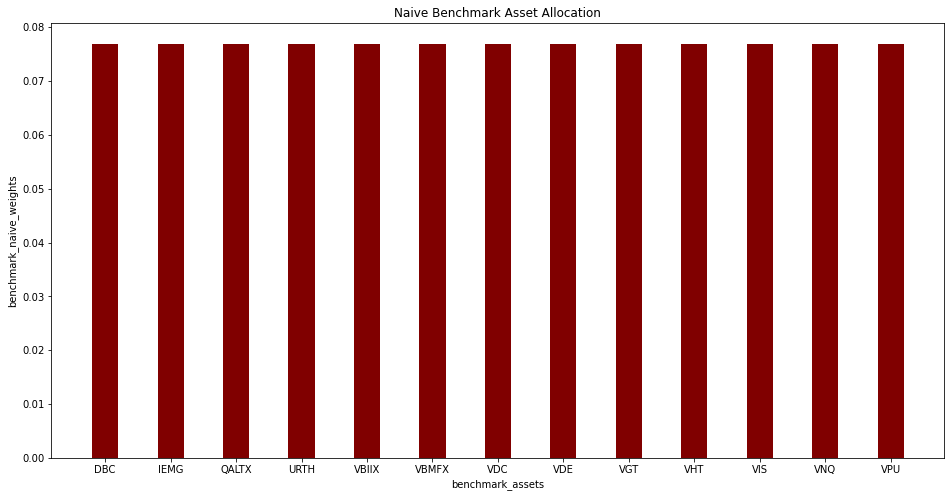

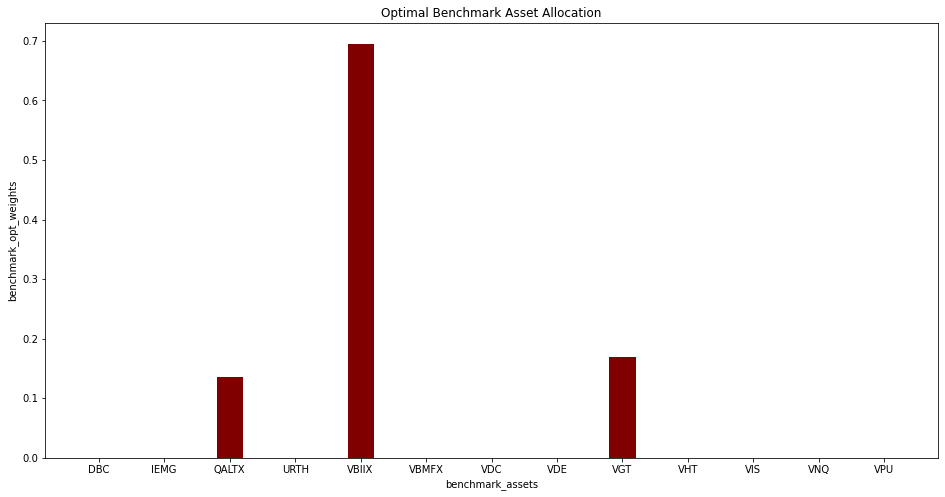

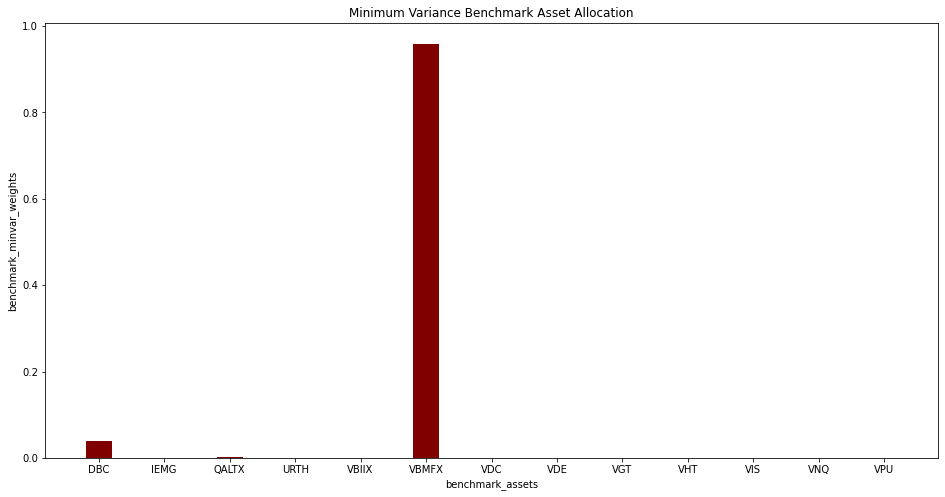

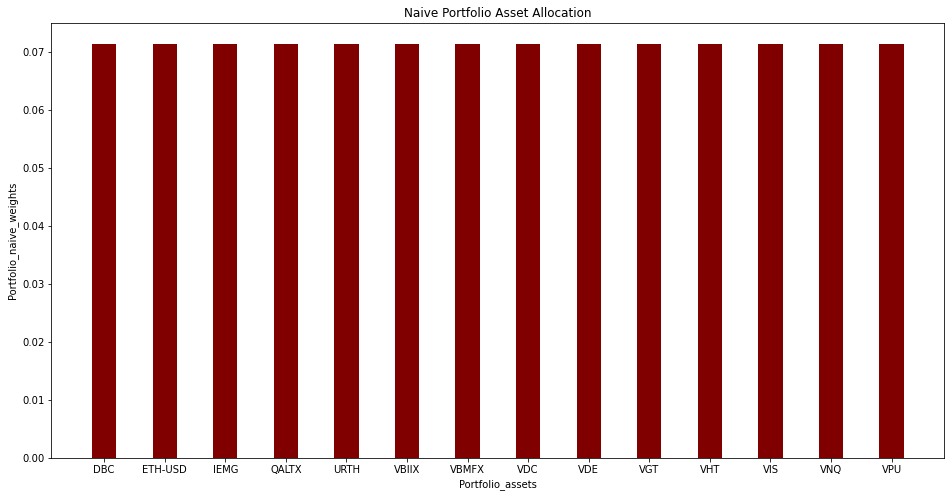

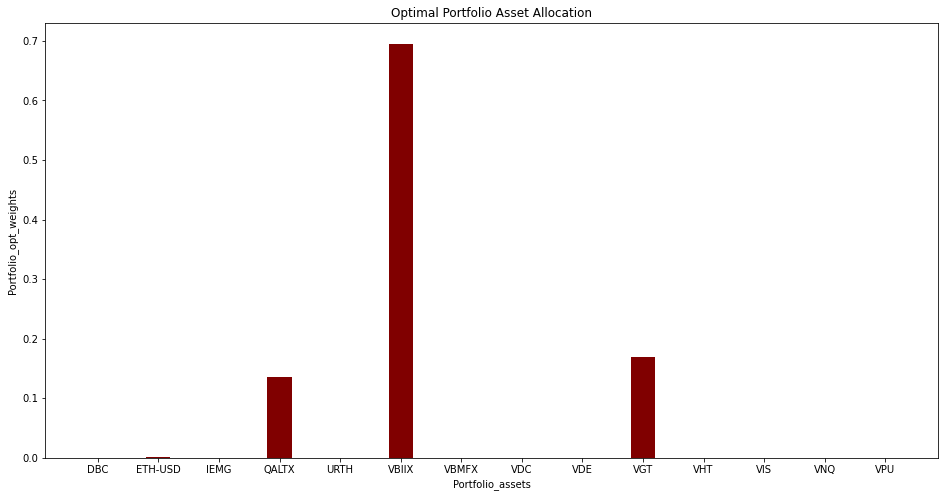

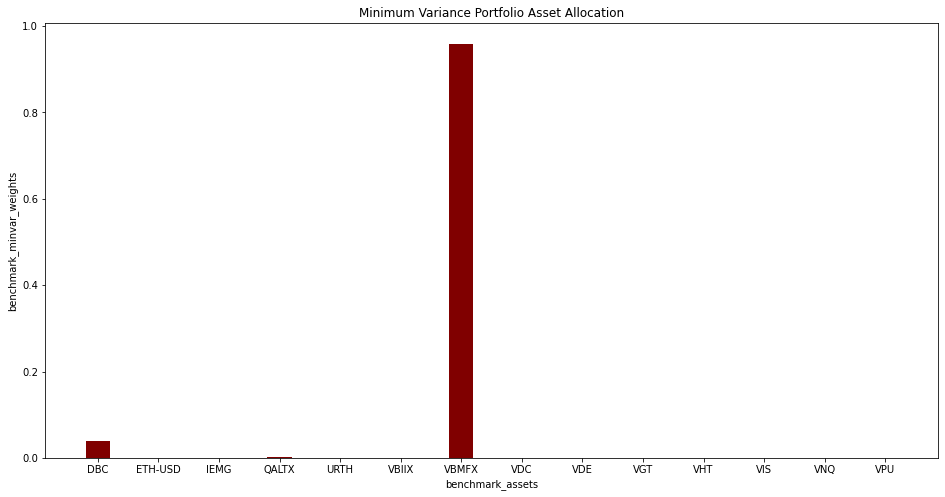

Computing the differences between the performance metrics of the optimal portfolio and the optimal benchmark indicates that:
 the beta of the optimal portfolio is higher than that of the optimal benchmark by 0.0007989284401465069, the Sharpe ratio of the optimal portfolio is higher than that of the optimal benchmark by 0.00014919929021406375. While the expected returns of the optimal portfolio is lower than that of the optimal benchmark by 6.853583438332089e-05, the standard deviation of the optimal portfolio is lower than that of the optimal benchmark by 6.012209052642936e-05, the Treynor's ratio of the optimal portfolio is lower than that of the optimal benchmark by 0.0012972114116314715, the Jensen's alpha of the optimal portfolio is lower than that of the optimal benchmark by 0.00016615890729303195.


Computing the differences between the performance metrics of the naive portfolio and the naive benchmark indicates that:
 the expected returns of the naive portfolio is higher than th

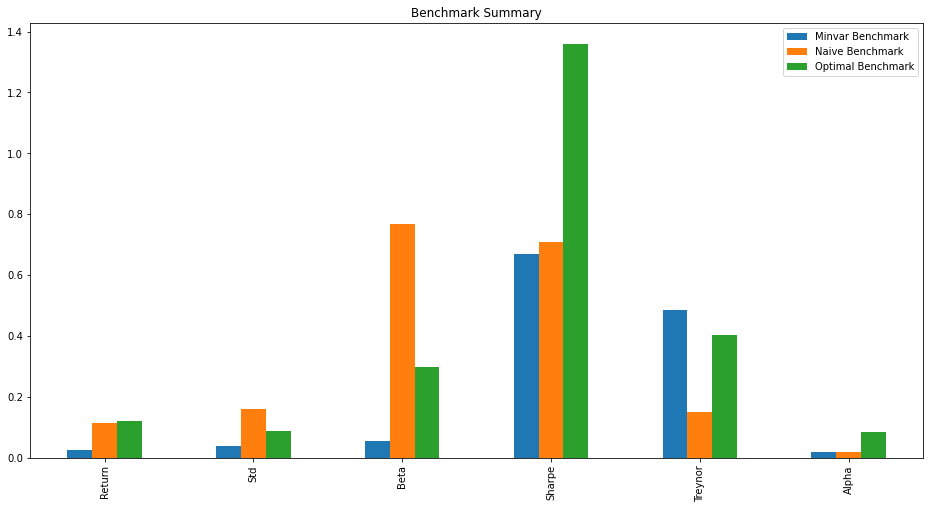

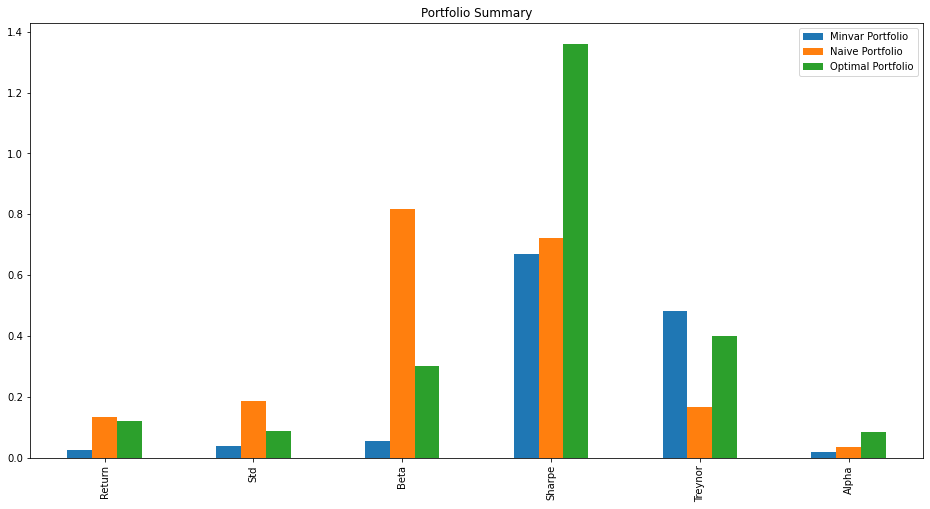

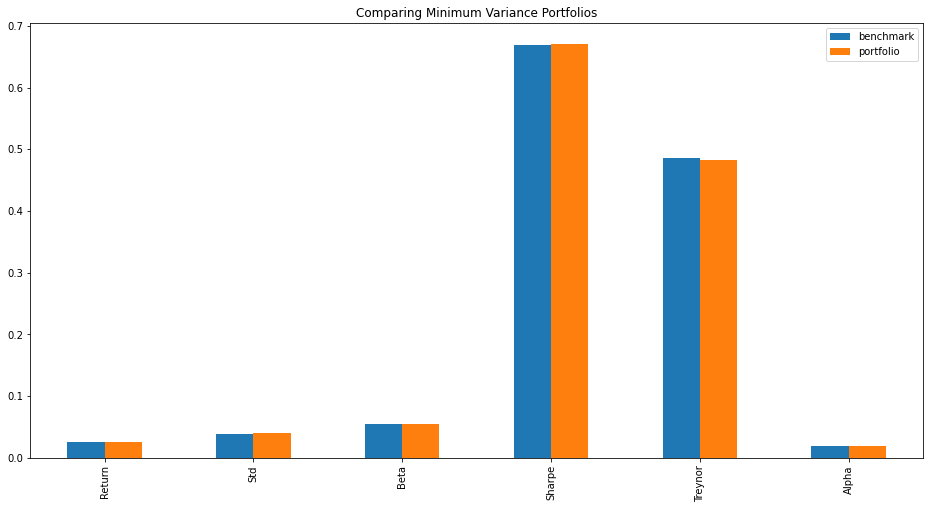

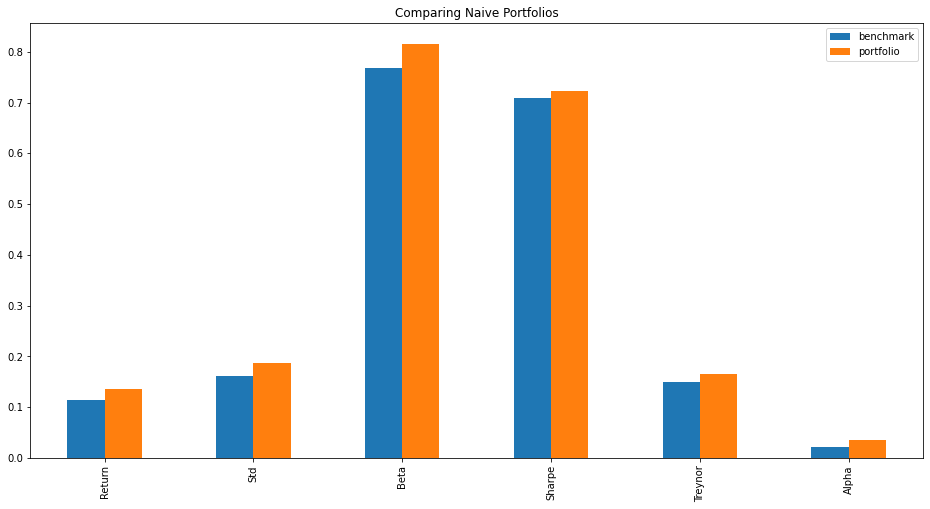

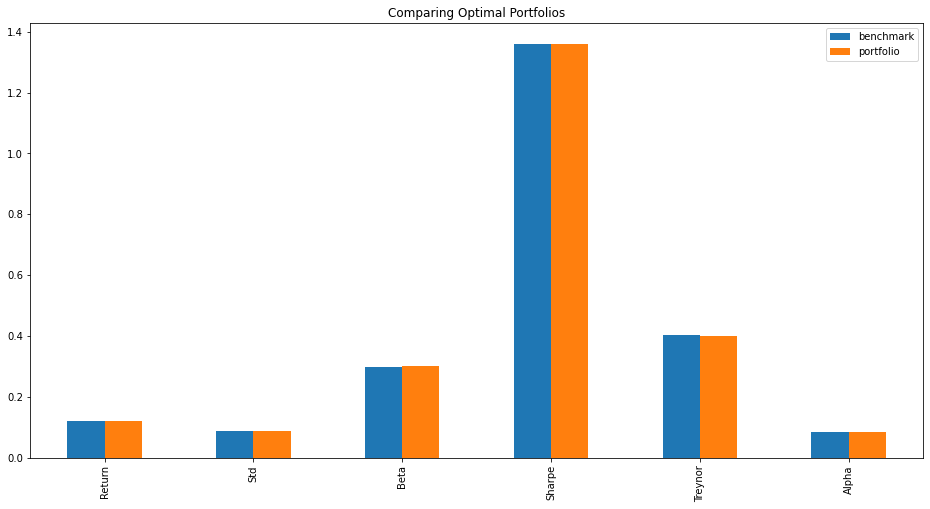

In [24]:

#Step 5

#Present the optimization process and display compositions of Naive, minvar, and optimal (NOT DONE) #################
# creating the bar plots for the benchmarks

#Displaying the weights allocation resulting from the optimization
#Naive Benchmark
fig = plt.figure(figsize=(16,8))
plt.bar(benchmark_assets, benchmark_naive_weights, color ='maroon', width = 0.4)
plt.xlabel("benchmark_assets")
plt.ylabel("benchmark_naive_weights")
plt.title("Naive Benchmark Asset Allocation")
plt.savefig("Naive_Benchmark_Asset_Allocation.png")  #(EXPORTED)
plt.show()
#Optimal Benchmark
fig = plt.figure(figsize=(16,8))
plt.bar(benchmark_assets, benchmark_opt_weights, color ='maroon', width = 0.4)
plt.xlabel("benchmark_assets")
plt.ylabel("benchmark_opt_weights")
plt.title("Optimal Benchmark Asset Allocation")
plt.savefig("Optimal_Benchmark_Asset_Allocation.png") #(EXPORTED)
plt.show()
#Minvar Benchmark
fig = plt.figure(figsize=(16,8))
plt.bar(benchmark_assets, benchmark_minvar_weights, color ='maroon', width = 0.4)
plt.xlabel("benchmark_assets")
plt.ylabel("benchmark_minvar_weights")
plt.title("Minimum Variance Benchmark Asset Allocation")
plt.savefig("Minimum Variance_Benchmark_Asset_Allocation.png") #(EXPORTED)
plt.show()
#Average simulated Benchmark portfolio???????????????

#Naive portfolio
fig = plt.figure(figsize=(16,8))
plt.bar(portfolio_assets, portfolio_naive_weights, color ='maroon', width = 0.4)
plt.xlabel("Portfolio_assets")
plt.ylabel("Portfolio_naive_weights")
plt.title("Naive Portfolio Asset Allocation")
plt.savefig("Naive_Portfolio_Asset_Allocation.png")  #(EXPORTED)
plt.show()
#Optimal portfolio
fig = plt.figure(figsize=(16,8))
plt.bar(portfolio_assets, portfolio_opt_weights, color ='maroon', width = 0.4)
plt.xlabel("Portfolio_assets")
plt.ylabel("Portfolio_opt_weights")
plt.title("Optimal Portfolio Asset Allocation")
plt.savefig("Optimal_Portfolio_Asset_Allocation.png")  #(EXPORTED)
plt.show()
#Minvar portfolio
fig = plt.figure(figsize=(16,8))
plt.bar(portfolio_assets, portfolio_minvar_weights, color ='maroon', width = 0.4)
plt.xlabel("benchmark_assets")
plt.ylabel("benchmark_minvar_weights")
plt.title("Minimum Variance Portfolio Asset Allocation")
plt.savefig("Minimum Variance_Portfolio_Asset_Allocation.png") #(EXPORTED)
plt.show()
#Average simulated portfolio?????????????????????????

#Presenting the performance resulting from these alloctions  (DONE) 
#portfolio_summary_df
dfi.export(portfolio_summary_df,'portfolio_summary_df.png')   #(EXPORTED)
dfi.export(benchmark_summary_df,'benchmark_summary_df.png')   #(EXPORTED)

#display(benchmark_summary_df)
benchmark_summary_df2=benchmark_summary_df.to_dict()
portfolio_summary_df2=portfolio_summary_df.to_dict()
benchmark_summary_graph={}
portfolio_summary_graph={}

for key in benchmark_summary_df:
    temp1=benchmark_summary_df2[key]
    for asset in benchmark_assets:
        del temp1[asset]
        benchmark_summary_graph[key]=temp1

for key in portfolio_summary_df:
    temp2=portfolio_summary_df2[key]
    for asset in portfolio_assets:
        del temp2[asset]
        portfolio_summary_graph[key]=temp2

portfolio_benchmark={}
        
for portfolio in portfolio_summary_graph:
    for benchmark in benchmark_summary_graph:
        portfolio_benchmark[portfolio+'_'+benchmark]=[portfolio_summary_graph[portfolio],benchmark_summary_graph[benchmark]]

        
#Generating bar graph for benchmark summary
benchmark_summary_df3=pd.DataFrame(benchmark_summary_graph)
benchmark_summary_plot=benchmark_summary_df3.plot(kind='bar',title='Benchmark Summary',figsize=(16,8))
benchmark_summary_plot.figure.savefig('benchmark_summary_plot') #(EXPORTED)

#Generating bar graph for portfolio summary
portfolio_summary_df3=pd.DataFrame(portfolio_summary_graph)
portfolio_summary_plot=portfolio_summary_df3.plot(kind='bar',title='Portfolio Summary',figsize=(16,8))
portfolio_summary_plot.figure.savefig('portfolio_summary_plot') #(EXPORTED)

#Metrics Dictionary

opt_metrics=[benchmark_opt_metrics,portfolio_opt_metrics]
naive_metrics=[benchmark_naive_metrics,portfolio_naive_metrics]
minvar_metrics=[benchmark_minvar_metrics,portfolio_minvar_metrics]


opt_metrics_dict=dict(zip(["benchmark","portfolio"],opt_metrics))
naive_metrics_dict=dict(zip(["benchmark","portfolio"],naive_metrics))
minvar_metrics_dict=dict(zip(["benchmark","portfolio"],minvar_metrics))

#generating graphs to compare benchmark and portfolio
minvar_metrics_df=pd.DataFrame(minvar_metrics_dict,index=metrics)
minvar_metrics_df=minvar_metrics_df
minvar_metrics_plot=minvar_metrics_df.plot(kind='bar',title='Comparing Minimum Variance Portfolios',figsize=(16,8))
minvar_metrics_plot.figure.savefig('minvar_metrics_plot')  #(EXPORTED)
 
naive_metrics_df=pd.DataFrame(naive_metrics_dict,index=metrics)
naive_metrics_df=naive_metrics_df
naive_metrics_plot=naive_metrics_df.plot(kind='bar',title='Comparing Naive Portfolios',figsize=(16,8))
naive_metrics_plot.figure.savefig('naive_metrics_plot')    #(EXPORTED)

opt_metrics_df=pd.DataFrame(opt_metrics_dict,index=metrics)
opt_metrics_df=opt_metrics_df
opt_metrics_plot=opt_metrics_df.plot(kind='bar',title='Comparing Optimal Portfolios',figsize=(16,8))
opt_metrics_plot.figure.savefig('opt_metrics_plot')       #(EXPORTED)

opt_difference=[]
naive_difference=[]
minvar_difference=[]
for p,b in zip(portfolio_opt_metrics , benchmark_opt_metrics): opt_difference.append((p-b))
for p,b in zip(portfolio_naive_metrics , benchmark_naive_metrics): naive_difference.append(p-b)
for p,b in zip(portfolio_minvar_metrics , benchmark_minvar_metrics): minvar_difference.append(p-b)

opt_difference_dict=dict(zip(metrics,opt_difference))       # Can be used for tables
naive_difference_dict=dict(zip(metrics,naive_difference))   # Can be used for tables
minvar_difference_dict=dict(zip(metrics,minvar_difference)) # Can be used for tables
#a=portfolio_opt_metrics - benchmark_opt_metrics
#b=portfolio_naive_metrics - benchmark_naive_metrics
#c=portfolio_minvar_metrics - benchmark_minvar_metrics



# Generating text for difference between optimal portfolio and optimal benchmark
opt_L1=[]
opt_L2=[]
opt_g1="Computing the differences between the performance metrics of the optimal portfolio and the optimal benchmark indicates that:\n"        
opt_S1=''
opt_S2=''

for metric,value in zip(word_list,opt_difference):
    if value>0:
        s2=(' the ' +str(metric)+ ' of the optimal portfolio is higher than that of the optimal benchmark by ' + str(abs(value)) + ',')
        opt_L1.append(s2)
    if value<0:
        s2=(' the '+str(metric)+' of the optimal portfolio is lower than that of the optimal benchmark by ' + str(abs(value)) + ',')
        opt_L2.append(s2)


for l1 in opt_L1:
    opt_S1=opt_S1+l1
for l2 in opt_L2:
    opt_S2=opt_S2+l2

opt_statement=((opt_g1+opt_S1)[ :-1]+'. While'+opt_S2)[:-1]+"."
#final_statement_1=Statement_1[:-1]+"."
print(opt_statement+'\n\n')

# Generating text for difference between naive portfolio and naive benchmark
naive_L1=[]
naive_L2=[]
naive_g1="Computing the differences between the performance metrics of the naive portfolio and the naive benchmark indicates that:\n"        
naive_S1=''
naive_S2=''

for metric,value in zip(word_list,naive_difference):
    if value>0:
        s2=(' the ' +str(metric)+ ' of the naive portfolio is higher than that of the naive benchmark by ' + str(abs(value)) + ',')
        naive_L1.append(s2)
    if value<0:
        s2=(' the '+str(metric)+' of the naive portfolio is lower than that of the naive benchmark by ' + str(abs(value)) + ',')
        naive_L2.append(s2)


for l1 in naive_L1:
    naive_S1=naive_S1+l1
for l2 in naive_L2:
    naive_S2=naive_S2+l2

naive_statement=((naive_g1+naive_S1)[ :-1]+'. While'+naive_S2)[:-1]+"."
#final_statement_1=Statement_1[:-1]+"."
print(naive_statement+'\n\n')


# Generating text for difference between minimum variance portfolio and minimum variance benchmark
minvar_L1=[]
minvar_L2=[]
minvar_g1="Computing the differences between the performance metrics of the minimum variance portfolio and the minimum variance benchmark indicates that:\n"        
minvar_S1=''
minvar_S2=''

for metric,value in zip(word_list,minvar_difference):
    if value>0:
        minvar_s2=(' the ' +str(metric)+ ' of the minimum variance portfolio is higher than that of the minimum variance benchmark by ' + str(abs(value)) + ',')
        minvar_L1.append(minvar_s2)
    if value<0:
        minvar_s2=(' the '+str(metric)+' of the minimum variance portfolio is lower than that of the minimum variance benchmark by ' + str(abs(value)) + ',')
        minvar_L2.append(minvar_s2)


for l1 in minvar_L1:
    minvar_S1=minvar_S1+l1
for l2 in naive_L2:
    minvar_S2=minvar_S2+l2

minvar_statement=((minvar_g1+minvar_S1)[ :-1]+'. While'+minvar_S2)[:-1]+"."
#final_statement_1=Statement_1[:-1]+"."
print(minvar_statement+'\n\n')


path ="C:/Users/Zeina/"

#Exporting the interpretation
with open(path+'difference_interpretation.txt','w') as f:
    f.write(opt_statement+'\n\n'+naive_statement+'\n\n'+minvar_statement+'\n\n')
    f.close()






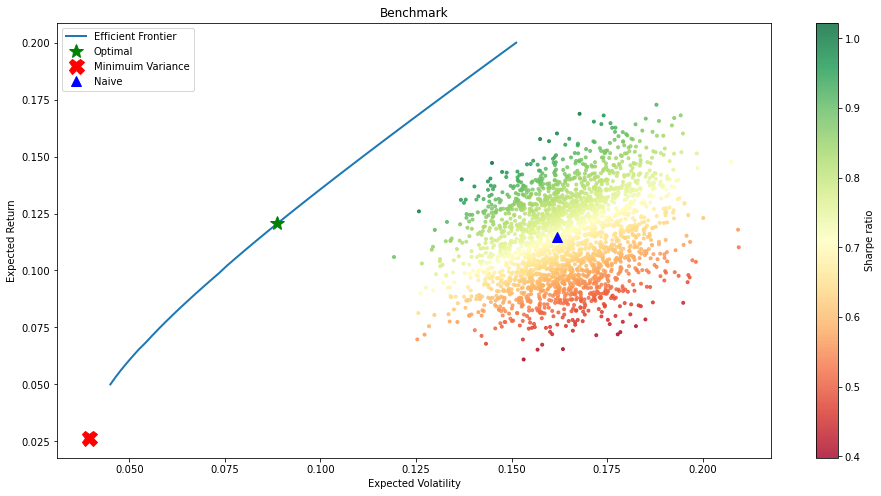

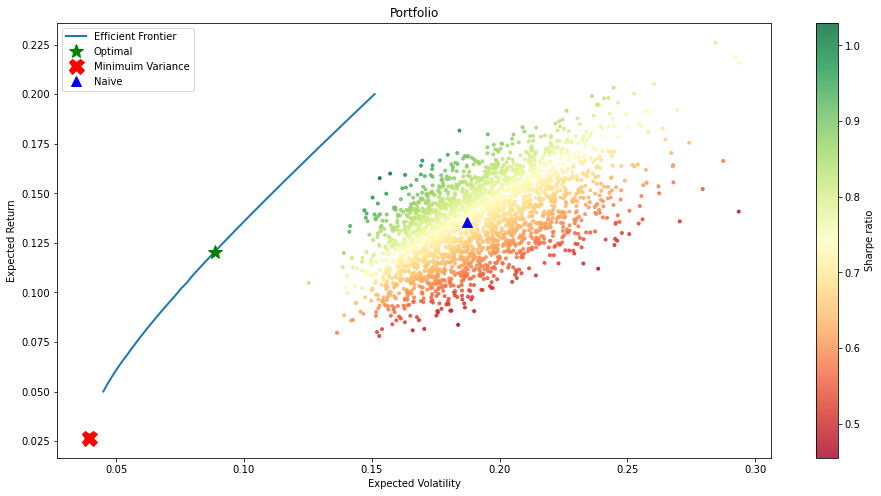

In [15]:
#Step 6
#Present the efficient frontier graphs (DONE)
#colormap options PiYG PRGn BrBG PuOr RdGy RdGy RdBu RdYlBu RdYlGn Spectral coolwarm bwr seismic

#plotting the benchmark
plt.figure(figsize=(16,8))
plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(benchmark_target_stds,benchmark_target_returns,'-',lw=2.0,label='Efficient Frontier') #plot efficient frontier
plt.plot(benchmark_opt_std,benchmark_opt_return,'g*',markersize=15.0,label='Optimal') #plot optimal
plt.plot(benchmark_minvar_std,benchmark_minvar_return,'rX',markersize=15.0,label='Minimuim Variance') #plot minvar
plt.plot(benchmark_naive_std,benchmark_naive_return,'b^',markersize=10.0,label='Naive') #plot Naive
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Benchmark")
plt.colorbar(label='Sharpe ratio')
plt.legend(bbox_to_anchor=(0,1),loc='upper left',ncol=1)
plt.savefig("Benchmark_EF.png")                                #(EXPORTED)
plt.show()
#plt.plot(x,y)  portfolio

#Plotting the portfolio
plt.figure(figsize=(16,8))
plt.scatter(portfolio_stds,portfolio_returns,c=portfolio_returns/portfolio_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(portfolio_target_stds,portfolio_target_returns,'-',lw=2.0,label='Efficient Frontier') #plot efficient frontier
plt.plot(portfolio_opt_std,portfolio_opt_return,'g*',markersize=15.0,label='Optimal') #plot optimal
plt.plot(portfolio_minvar_std,portfolio_minvar_return,'rX',markersize=15.0,label='Minimuim Variance') #plot minvar
plt.plot(portfolio_naive_std,portfolio_naive_return,'b^',markersize=10.0,label='Naive') #plot Naive
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Portfolio")
plt.colorbar(label='Sharpe ratio')
plt.legend(bbox_to_anchor=(0,1),loc='upper left',ncol=1)
plt.savefig("Portfolio_EF.png")                             #(EXPORTED)
plt.show()





In [20]:
################################################################################################################################
################################                 Statistical Analysis                     ######################################
################################################################################################################################
#import seaborn as sns
#from skylearn import datasets
#%matplotlib inline

#Step 7
#present the t-test  (DONE) 

import scipy.stats as stats

#perform two sample t-test with equal variances
test1=stats.ttest_ind(a=portfolio_returns, b=benchmark_returns, equal_var=True)
test2=stats.ttest_ind(a=portfolio_stds, b=benchmark_stds, equal_var=True)
test3=stats.ttest_ind(a=portfolio_betas, b=benchmark_betas, equal_var=True)
test4=stats.ttest_ind(a=portfolio_sr_list, b=benchmark_sr_list, equal_var=True)
test5=stats.ttest_ind(a=portfolio_tr_list, b=benchmark_tr_list, equal_var=True)
test6=stats.ttest_ind(a=portfolio_alpha_list, b=benchmark_alpha_list, equal_var=True)

ttest_keys=['t-statistic','p-value']
word_list=['expected returns', 'standard deviation','beta','Sharpe ratio','Treynor\'s ratio','Jensen\'s alpha']
#print(test2)
#print(test3)
#print(test4)
#print(test5)
#print(test6)

test1=list(test1)
test2=list(test2)
test3=list(test3)
test4=list(test4)
test5=list(test5)
test6=list(test6)

alpha=0.05
tstat_list=[test1[0],test2[0],test3[0],test4[0],test5[0],test6[0]]
pvalue_list=[test1[1],test2[1],test3[1],test4[1],test5[1],test6[1]]

ttest_dict={ 'T-statistic':tstat_list,'P-value (alpha=0.05)':pvalue_list}
ttest_df=pd.DataFrame(ttest_dict,index=word_list)
display(ttest_df)
#The two hypotheses for this particular two sample t-test are as follows:
#H0: µ1 = µ2 (the two population means are equal)
#HA: µ1 ≠µ2 (the two population means are not equal)

ttest_statements=[]
for pvalue,word in zip(pvalue_list,word_list):
    s1=("After conducting an independent two-side T-test for "+str(word)+", we determine that")
    if pvalue>alpha:
        s2=(' the p-value of our test ('+str(pvalue)+') is greater than alpha ('+str(alpha)+'). Therefore, we fail to reject the null hypothesis of the T-test,')
        s3=(' indicating that we do not have sufficient evidence to say that the mean '+ str(word)+' between both samples is different.')
    if pvalue<alpha:
        s2=(' the p-value of our test ('+str(pvalue)+') is less than alpha ('+str(alpha)+'). Therefore, we reject the null hypothesis of the T-test,')
        s3=(' indicating that we have sufficient evidence to say that the mean '+ str(word)+' between both samples is different.')
    ttest_statements.append(s1+s2+s3+"\n")

#Because the p-value of our test (0.53005) is greater than alpha = 0.05, we fail to reject 
#the null hypothesis of the test. We do not have sufficient evidence to say that the mean height 
#of plants between the two populations is different.
ttest_interpretation=''
for i in range (0,len(ttest_statements)): ttest_interpretation=ttest_interpretation+ttest_statements[i]+'\n'

path ="C:/Users/Zeina/"

#Exporting the interpretation
with open(path+'T-Test_interpretation.txt','w') as f:
    f.write(ttest_interpretation)
    f.close()

dfi.export(ttest_df,'ttest_df.png') # Exporting the table

print(ttest_interpretation)
  

,T-statistic,P-value (alpha=0.05)
expected returns,37.847767,7.488178e-276
standard deviation,50.717896,0.000000e+00
beta,26.524190,3.758786e-145
Sharpe ratio,3.753393,1.764370e-04
Treynor's ratio,23.543040,2.576625e-116
Jensen's alpha,27.927850,1.268215e-159


After conducting an independent two-side T-test for expected returns, we determine that the p-value of our test (7.488177764018048e-276) is less than alpha (0.05). Therefore, we reject the null hypothesis of the T-test, indicating that we have sufficient evidence to say that the mean expected returns between both samples is different.

After conducting an independent two-side T-test for standard deviation, we determine that the p-value of our test (0.0) is less than alpha (0.05). Therefore, we reject the null hypothesis of the T-test, indicating that we have sufficient evidence to say that the mean standard deviation between both samples is different.

After conducting an independent two-side T-test for beta, we determine that the p-value of our test (3.758785967666523e-145) is less than alpha (0.05). Therefore, we reject the null hypothesis of the T-test, indicating that we have sufficient evidence to say that the mean beta between both samples is different.

After conducting an indep

In [25]:
display(portfolio_summary_df)
display(benchmark_summary_df)


,Minvar Portfolio,Naive Portfolio,Optimal Portfolio
0,,,
DBC,0.040000,0.071429,0.000000
ETH-USD,0.000000,0.071429,0.001000
IEMG,0.000000,0.071429,0.000000
QALTX,0.002000,0.071429,0.135000
URTH,0.000000,0.071429,0.000000
VBIIX,0.000000,0.071429,0.695000
VBMFX,0.959000,0.071429,0.000000
VDC,0.000000,0.071429,0.000000
VDE,0.000000,0.071429,0.000000


,Minvar Benchmark,Naive Benchmark,Optimal Benchmark
0,,,
DBC,0.039000,0.076923,0.000000
IEMG,0.000000,0.076923,0.000000
QALTX,0.002000,0.076923,0.136000
URTH,0.000000,0.076923,0.000000
VBIIX,0.000000,0.076923,0.695000
VBMFX,0.959000,0.076923,0.000000
VDC,0.000000,0.076923,0.000000
VDE,0.000000,0.076923,0.000000
VGT,0.000000,0.076923,0.169000


In [32]:
display(market_data.T) # Present data and discuss it as an initial result then discuss rets, std, cov, etc...
(market_data.T).to_csv("market_Data.csv") 



Date,2017-11-20,2017-11-27,2017-12-04,2017-12-11,2017-12-18,2017-12-25,2018-01-01,2018-01-08,2018-01-15,2018-01-22,...,2021-12-20,2021-12-27,2022-01-03,2022-01-10,2022-01-17,2022-01-24,2022-01-31,2022-02-07,2022-02-14,2022-02-21
DBC,15.973323,15.837296,15.506948,15.390354,15.740136,16.138496,16.235657,16.488276,16.400831,16.760330,...,20.660000,20.780001,21.240000,21.780001,22.010000,22.340000,22.830000,23.129999,23.180000,23.469999
ETH-USD,471.329987,465.852997,441.721008,719.974976,694.148010,756.732971,1153.170044,1366.770020,1049.579956,1246.010010,...,4067.328125,3829.564941,3157.751465,3350.921875,2535.039062,2603.466553,3057.476074,2883.463379,2628.648438,2621.801758
IEMG,50.617352,48.899857,48.847015,49.146473,49.419510,50.995075,53.101192,53.585159,54.481377,56.184196,...,59.549999,59.860001,59.830002,61.180000,59.790001,57.799999,59.400002,59.430000,59.500000,57.930000
QALTX,1.306850,1.300468,1.304297,1.315783,1.322164,1.282601,1.360722,1.383094,1.385726,1.406782,...,9.834454,8.796914,9.930000,9.910000,9.600000,9.540000,9.730000,9.810000,9.730000,9.740000
URTH,79.687859,80.173996,80.329926,80.669289,80.806870,81.573997,83.712646,84.851402,85.443932,87.091888,...,134.403809,135.243347,133.190002,133.000000,126.190002,125.940002,128.220001,126.639999,125.099998,125.279999
VBIIX,10.083366,10.065693,10.086946,10.095800,10.016099,10.070165,10.057766,10.013343,9.951149,9.951149,...,11.734498,11.853610,11.681860,11.651907,11.651907,11.592000,11.482171,11.470000,11.450000,11.410000
VBMFX,9.710656,9.701641,9.721537,9.739606,9.676365,9.717038,9.710719,9.683538,9.629186,9.638250,...,11.138704,11.155622,11.002876,10.972921,10.972921,10.922999,10.813170,10.780000,10.750000,10.710000
VDC,125.999397,129.359985,130.256119,130.569763,131.829239,131.811188,131.892410,131.305756,134.554993,136.152557,...,195.050003,199.880005,200.589996,199.759995,195.820007,194.770004,194.970001,194.220001,196.160004,196.059998
VDE,79.139908,81.258812,80.552513,79.829185,84.404587,84.738571,88.018501,90.767479,89.491463,90.741783,...,76.930000,77.610001,85.519997,90.050003,86.410004,90.790001,95.180000,97.220001,93.860001,95.379997
VGT,160.417236,156.908051,156.908051,159.164642,159.471848,157.928314,164.418762,166.269089,168.742584,171.791275,...,456.489990,458.170013,434.859985,433.470001,402.429993,409.839996,416.079987,405.959991,398.089996,403.820007


In [31]:
display(market_rets) #Present the returns and discuss further calculations 
(market_rets.T).to_csv("market_returns.csv") 

,DBC,ETH-USD,IEMG,QALTX,URTH,VBIIX,VBMFX,VDC,VDE,VGT,VHT,VIS,VNQ,VPU,^GSPC
Date,,,,,,,,,,,,,,,
2017-11-27,-0.008552,-0.011688,-0.034520,-0.004895,0.006082,-0.001754,-0.000929,0.026322,0.026422,-0.022118,0.017999,0.028935,-0.004247,0.011567,0.015178
2017-12-04,-0.021079,-0.053192,-0.001081,0.002940,0.001943,0.002109,0.002049,0.006904,-0.008730,0.000000,-0.004324,0.010888,-0.006642,-0.009292,0.003506
2017-12-11,-0.007547,0.488538,0.006112,0.008768,0.004216,0.000877,0.001857,0.002405,-0.009020,0.014279,0.006125,-0.001355,0.012418,-0.016286,0.009127
2017-12-18,0.022473,-0.036531,0.005540,0.004838,0.001704,-0.007926,-0.006514,0.009600,0.055733,0.001928,-0.002745,0.016937,-0.038948,-0.036069,0.002810
2017-12-25,0.024994,0.086325,0.031384,-0.030379,0.009449,0.005383,0.004195,-0.000137,0.003949,-0.009726,-0.002850,0.002955,0.029329,0.004987,-0.003633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,0.014882,0.026635,-0.033850,-0.006270,-0.001983,-0.005155,-0.004560,-0.005377,0.049446,0.018246,0.003680,-0.019077,-0.002664,-0.011391,0.007681
2022-01-31,0.021697,0.160746,0.027305,0.019720,0.017942,-0.009520,-0.010106,0.001026,0.047221,0.015111,0.017024,0.006594,0.000667,0.004773,0.015378
2022-02-07,0.013055,-0.058598,0.000505,0.008188,-0.012399,-0.001061,-0.003072,-0.003854,0.021207,-0.024623,-0.010852,-0.005634,-0.016804,-0.021833,-0.018363


In [35]:

#Extra Steps
#remove the fixed income fund and repeat? (NOT DONE BUT SIMPLY OPEN A NEW FILE) #########3
#add more optimizations? ########

display(benchmark_df.T)
(benchmark_df.T).to_csv("Simulated_Benchmarks_Data.csv")

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DBC,0.044900,0.128820,0.095792,0.047237,0.140526,0.037967,0.080497,0.100379,0.055886,0.012358,...,0.020807,0.190476,0.104205,0.058707,0.146872,0.071353,0.046691,0.140721,0.014754,0.025032
IEMG,0.036566,0.089666,0.114250,0.174592,0.048790,0.112150,0.081094,0.152830,0.132204,0.105606,...,0.079451,0.031445,0.140596,0.120034,0.005141,0.098489,0.093850,0.063519,0.002595,0.089633
QALTX,0.113496,0.007514,0.143740,0.041816,0.082931,0.105471,0.086533,0.082871,0.089195,0.029556,...,0.001736,0.013736,0.035314,0.104919,0.140364,0.146340,0.086167,0.016774,0.169012,0.016255
URTH,0.050662,0.124987,0.043551,0.081347,0.026449,0.137331,0.018327,0.021717,0.073917,0.068960,...,0.079499,0.088703,0.006662,0.122899,0.044899,0.118004,0.103433,0.120538,0.015970,0.144101
VBIIX,0.006719,0.073486,0.017926,0.031102,0.079910,0.008646,0.107090,0.057095,0.124567,0.129559,...,0.000455,0.055151,0.015491,0.043234,0.089885,0.125411,0.072080,0.077197,0.145036,0.011113
VBMFX,0.135100,0.041392,0.007722,0.026487,0.127583,0.004425,0.000036,0.091348,0.093907,0.080560,...,0.141925,0.056411,0.072017,0.015689,0.046602,0.035204,0.080926,0.057387,0.015806,0.073283
VDC,0.128317,0.020646,0.127061,0.077602,0.107464,0.026752,0.147877,0.092421,0.020087,0.097161,...,0.118306,0.072006,0.088377,0.040912,0.014900,0.135868,0.104017,0.090753,0.173693,0.083071
VDE,0.103914,0.133268,0.065628,0.122044,0.048149,0.113913,0.106453,0.030772,0.069216,0.086258,...,0.081135,0.099799,0.104180,0.097982,0.136425,0.067350,0.029626,0.107413,0.035950,0.105067
VGT,0.074764,0.057121,0.112338,0.100889,0.049733,0.065186,0.082862,0.061518,0.021068,0.052922,...,0.187777,0.177396,0.118505,0.117704,0.049442,0.005128,0.106051,0.051117,0.067591,0.046185
VHT,0.041365,0.092166,0.130933,0.011831,0.111955,0.180330,0.010361,0.075407,0.136052,0.131248,...,0.020017,0.005398,0.036430,0.110187,0.140140,0.016401,0.001555,0.089095,0.012796,0.139370


In [36]:

display(portfolio_df.T)
(portfolio_df.T).to_csv("Simulated_Portfolios_Data.csv")

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DBC,0.148256,0.066788,0.126900,0.087813,0.121234,0.012324,0.055580,0.100296,0.102853,0.033357,...,0.026968,0.100266,0.013930,0.044585,0.012268,0.127152,0.038105,0.168625,0.116934,0.041802
ETH-USD,0.025891,0.109854,0.033017,0.078925,0.027505,0.068223,0.121655,0.084677,0.043515,0.012287,...,0.033861,0.096241,0.151555,0.091497,0.064439,0.100597,0.095219,0.019071,0.143161,0.099712
IEMG,0.019572,0.083803,0.122846,0.031766,0.042934,0.098117,0.048513,0.096351,0.069073,0.152368,...,0.164621,0.051265,0.102567,0.121892,0.008735,0.112876,0.005484,0.043215,0.070492,0.064289
QALTX,0.044587,0.067254,0.033081,0.113052,0.049711,0.068263,0.139066,0.030522,0.041888,0.014019,...,0.017754,0.117821,0.016348,0.022383,0.051118,0.062333,0.030916,0.014154,0.080699,0.057219
URTH,0.149195,0.118646,0.137736,0.113270,0.075013,0.078528,0.071385,0.031957,0.108086,0.086197,...,0.035675,0.096683,0.076152,0.028594,0.076799,0.105547,0.081826,0.033636,0.022617,0.095796
VBIIX,0.141551,0.002628,0.063618,0.033685,0.093289,0.085152,0.096637,0.088330,0.025771,0.038262,...,0.167315,0.070825,0.042302,0.078593,0.122700,0.026941,0.134576,0.154512,0.033719,0.115991
VBMFX,0.126208,0.006443,0.072899,0.089373,0.018777,0.124168,0.121231,0.070574,0.046954,0.061481,...,0.105535,0.059921,0.072097,0.031886,0.118149,0.065125,0.050139,0.057939,0.057952,0.014630
VDC,0.002586,0.130806,0.107170,0.101308,0.060529,0.098422,0.025878,0.085097,0.119576,0.025561,...,0.109458,0.067920,0.003908,0.054791,0.113172,0.020128,0.050563,0.062266,0.098435,0.113968
VDE,0.069823,0.048600,0.010342,0.078479,0.014716,0.016443,0.021638,0.000233,0.105348,0.046569,...,0.112528,0.110053,0.117873,0.130540,0.129910,0.058896,0.044824,0.166120,0.091526,0.093664
VGT,0.059102,0.047396,0.038190,0.009661,0.040127,0.130032,0.094971,0.026560,0.006193,0.106444,...,0.024504,0.074140,0.118038,0.111051,0.084066,0.037615,0.138209,0.053411,0.125971,0.108741


In [37]:
beta_list_df.to_csv("assets_beta_list_df.csv")